In [1]:
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
import os
import fiona
from statistics import mean, median
from pandas import read_csv
gp.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw' #To load KML files
import string
import xml.etree.ElementTree as et
import re
from collections import Counter

pd.options.display.max_columns = 999

# Florida

## VEST Documentation

Election results from the Florida Department of State (https://dos.myflorida.com/elections/data-statistics/elections-data/precinct-level-election-results/)

Precinct results from several sources.  
- Alachua, Bay, Bradford, Brevard, Calhoun, Citrus, Clay, Dixie, Escambia, Hardee, Hendry, Hernando, Indian River, Lafayette and Sarasota come from the Department of State.  
- Broward, Gadsden, Gilchrist, Manatee, Nassau, Santa Rosa, St. Johns, St. Lucie, and Union are from the Orlando Sentinel's precinct map for the 2016 presidential primary (http://interactive.orlandosentinel.com/elections/2016/presidential-primary/results/dem.html).  
- Baker, Charlotte, Franklin, Glades, Holmes, Jackson, Jefferson, Levy, Liberty, Madison, Monroe, Okeechobee, Orange, Seminole, Suwannee, Taylor, Wakulla, Walton, and Washinton come from the U.S. Census Bureau's 2020 Redistricting Data Program.  
- Collier, Columbia, DeSoto, Duval, Flagler, Gulf, Highlands, Hillsborough, Lake, Lee, Leon, Marion, Martin, Miami-Dade, Okaloosa, Osceola, Palm Beach, Pasco, Pinellas, Polk, Putnam, Sumter, and Volusia come from the counties.
- Hamilton was drawn based on a geocoded voter registration file.  
- Edits were made to Brevard, Charlotte, Escambia, Franklin, Indian River, Jefferson, Lafayette, Lake, and Lee, Miami-Dade, and St. Johns based on the voter registration file.  

Lake 108, Osceola 999, Palm Beach 8002, Seminole 900s, and Monroe's "Cumulative" precinct (the latter appears on the county's detailed results but not the DOS's precinct results file) don't have geography. Brevard 999, Broward Z073, Collier 450, Flagler 999, Hillborough 999, Leon 9000, Miami-Dade 100, and Pinellas 512 do have geography, but they are just the county election offices. Both groups represent some type of vote not assigned to a particular geography, like UOCAVA results, so these were distributed across the county by candidate proportional to the vote each precinct recorded.

G20PRERTRU - Donald J. Trump (Republican Party)  
G20PREDBID - Joseph R. Biden (Democratic Party)  
G20PRELJOR - Jo Jorgensen (Libertarian Party)  
G20PREODEL - Roque "Rocky" De La Fuente (Reform Party)  
G20PRESLAR - Gloria La Riva (Party for Socialism and Liberation)  
G20PREGHAW - Howie Hawkin (Green Party)  
G20PRECBLA - Don Blankenship (Constitution Party)  
G20PREOWRI - Write-in Votes  

## Load VEST File

In [2]:
vest_fl_20 = gp.read_file("./raw-from-source/VEST/fl_2020/fl_2020.shp")

In [3]:
vest_fl_20.columns

Index(['pct_std', 'county', 'precinct', 'G20PRERTRU', 'G20PREDBID',
       'G20PRELJOR', 'G20PREODEL', 'G20PRESLAR', 'G20PREGHAW', 'G20PRECBLA',
       'G20PREOWRI', 'geometry'],
      dtype='object')

In [4]:
data_columns = [col for col in vest_fl_20.columns if "G20" in col]

## Load Election Results

Fields and codes data https://files.floridados.gov/media/694099/precinct-level-results-data-definition-field-codes.pdfF

In [5]:
#This Data is from the FL department of state, and can only be downloaded county by county
all_files = os.listdir("./raw-from-source/Election_Results/2020-general-election-rev/")

In [6]:
#Minor processing note: For the FRA file, I replaced ""AJ"" w/ "AJ", so the load works

In [7]:
#Check that all files have the same number of columns
for i in all_files:
    if i !=".DS_Store":
        ref = "./raw-from-source/Election_Results/2020-general-election-rev/"
        file_ref = ref+i
        file_prev = pd.read_csv(file_ref,sep="\t",engine='python',index_col=None, header=None)
        if (file_prev.shape[1]!=19):
            print(i)
        #print(file_prev.shape)
    
#All the files have 19 columns, so they should be good to combine

In [8]:
li = []
for i in all_files:
    if i not in [".DS_Store","DAD_PctResults20201103recount.txt","BRO_PctResults20201103recount.txt"]:
        ref = "./raw-from-source/Election_Results/2020-general-election-rev/"
        file_ref = ref+i
        file_prev = pd.read_csv(file_ref,sep="\t",engine='python',index_col=None, header=None)
        li.append(file_prev)
frame = pd.concat(li, axis=0, ignore_index=True)
print(frame.shape)

(553307, 19)


https://files.floridados.gov/media/694099/precinct-level-results-data-definition-field-codes.pdf

In [9]:
col_rename_dict = {0: 'County Code (Three-character abbreviation)',
 1: 'County Name',
 2: 'Election Number',
 3: 'Election Date',
 4: 'Election Name',
 5: 'Unique Precinct Identifier',
 6: 'Precinct Polling Location',
 7: 'Total Registered Voters',
 8: 'Total Registered Republicans',
 9: 'Total Registered Democrats',
 10: 'Total Registered All Other Parties',
 11: 'Contest Name',
 12: 'District',
 13: 'Contest Code (Florida’s 6 digit contest codes)',
 14: 'Candidate/Retention/IssueName/WriteInsCast/OverVotes/UnderVotes',
 15: 'Candidate Party (abbreviation)',
 16: 'Candidate Florida Voter Registration System ID Number',
 17: 'DOE Assigned Candidate Number or Retention/Issue Number',
 18: 'Vote Total'}

In [10]:
frame.rename(columns = col_rename_dict, inplace = True)

In [11]:
races_list = races_list = ['President of the United States', 'Representative in Congress',
       'State Representative','State Senator','Retention of Carlos G. Muñiz','Amendment No. 1: Citizenship Requirement to Vote in Florida Elections',
       'Amendment No. 2: Raising Florida’s Minimum Wage',
       'Amendment No. 3: All Voters Vote in Primary Elections for State Legislature, Governor, and Cabinet',
       'Amendment No. 4: Voter Approval of Constitutional Amendments',
       'Amendment No. 5: Limitations on Homestead Property Tax Assessments; increased portability period to transfer accrued benefit',
       'Amendment No. 6: Ad Valorem Tax Discount for Spouses of Certain Deceased Veterans Who Had Permanent, Combat-Related Disabilities']

In [12]:
#Filter to the presidential results
frame =frame[frame['Contest Name'].isin(races_list)]

#Filter out the OverVotes and UnderVotes
filtered_frame = frame[~frame['Candidate/Retention/IssueName/WriteInsCast/OverVotes/UnderVotes'].isin(['OverVotes', 'UnderVotes'])]

#Clean up the precinct column
filtered_frame['Precinct Polling Location'] = filtered_frame['Precinct Polling Location'].astype(str)

#Deal with Dade County
filtered_frame["mod_col"]=filtered_frame.apply(lambda row:int(float(row['Precinct Polling Location'].split("PRECINCT ")[1])) if row['County Code (Three-character abbreviation)']=="DAD" else row['Unique Precinct Identifier'], axis=1)

#Make the precinct column at least 4 digits
filtered_frame["mod_col"]=filtered_frame["mod_col"].astype(str)
filtered_frame["modified_pre"]=filtered_frame["mod_col"].str.zfill(4)

#Make a column with the 3 letter county code and the precincts
filtered_frame["pct_std"]=filtered_frame['County Code (Three-character abbreviation)']+filtered_frame["modified_pre"]

<ipython-input-12-5edbeda0f2eb>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame['Precinct Polling Location'] = filtered_frame['Precinct Polling Location'].astype(str)
<ipython-input-12-5edbeda0f2eb>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame["mod_col"]=filtered_frame.apply(lambda row:int(float(row['Precinct Polling Location'].split("PRECINCT ")[1])) if row['County Code (Three-character abbreviation)']=="DAD" else row['Unique Precinct Identifier'], axis=1)
<ipython-input

In [13]:
# Cast the contest name and code columns to string to make the pivot col
filtered_frame["Contest Name"] = filtered_frame["Contest Name"].astype(str)
filtered_frame["Contest Code (Florida’s 6 digit contest codes)"] = filtered_frame["Candidate/Retention/IssueName/WriteInsCast/OverVotes/UnderVotes"].astype(str)

<ipython-input-13-46da4f0e8365>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame["Contest Name"] = filtered_frame["Contest Name"].astype(str)
<ipython-input-13-46da4f0e8365>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame["Contest Code (Florida’s 6 digit contest codes)"] = filtered_frame["Candidate/Retention/IssueName/WriteInsCast/OverVotes/UnderVotes"].astype(str)


In [14]:
filtered_frame['Candidate Party (abbreviation)'] = filtered_frame['Candidate Party (abbreviation)'].map({' ':'WRI'}).fillna(filtered_frame['Candidate Party (abbreviation)'])

<ipython-input-14-cc08b28a7227>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame['Candidate Party (abbreviation)'] = filtered_frame['Candidate Party (abbreviation)'].map({' ':'WRI'}).fillna(filtered_frame['Candidate Party (abbreviation)'])


In [15]:
filtered_frame['Candidate Party (abbreviation)'].unique()

array(['REP', 'DEM', 'LPF', 'REF', 'PSL', 'GRE', 'CPF', 'WRI', 'NPA',
       'NOP'], dtype=object)

In [16]:
# Create the pivot column with the contest name and the candidate
filtered_frame["pivot_col"] = filtered_frame["Contest Name"] + "-" + filtered_frame["Contest Code (Florida’s 6 digit contest codes)"] + "-" + "PARTY:" +filtered_frame['Candidate Party (abbreviation)']  

<ipython-input-16-fe582c8917a9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame["pivot_col"] = filtered_frame["Contest Name"] + "-" + filtered_frame["Contest Code (Florida’s 6 digit contest codes)"] + "-" + "PARTY:" +filtered_frame['Candidate Party (abbreviation)']


In [17]:
# Where it exists, add in the district to the pivot column
filtered_frame["pivot_col"] = np.where(filtered_frame["District"]!=" ",filtered_frame["pivot_col"] + "-" + filtered_frame["District"], filtered_frame["pivot_col"])

<ipython-input-17-d12f4a46ad53>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame["pivot_col"] = np.where(filtered_frame["District"]!=" ",filtered_frame["pivot_col"] + "-" + filtered_frame["District"], filtered_frame["pivot_col"])


### Pivot the Data

In [18]:
filtered_frame[filtered_frame["Contest Name"]== "Representative in Congress"]

,County Code (Three-character abbreviation),County Name,Election Number,Election Date,Election Name,Unique Precinct Identifier,Precinct Polling Location,Total Registered Voters,Total Registered Republicans,Total Registered Democrats,Total Registered All Other Parties,Contest Name,District,Contest Code (Florida’s 6 digit contest codes),Candidate/Retention/IssueName/WriteInsCast/OverVotes/UnderVotes,Candidate Party (abbreviation),Candidate Florida Voter Registration System ID Number,DOE Assigned Candidate Number or Retention/Issue Number,Vote Total,mod_col,modified_pre,pct_std,pivot_col
110,OKE,Okeechobee,10866,11/03/2020,2020 General Election,1,1-ABIDING HOPE WORSHIP CENTER,1593,0,0,0,Representative in Congress,District 17,Greg Steube,Greg Steube,REP,105486919,75229,929,1,0001,OKE0001,Representative in Congress-Greg Steube-PARTY:R...
111,OKE,Okeechobee,10866,11/03/2020,2020 General Election,2,2-BASINGER COMMUNITY CENTER,849,0,0,0,Representative in Congress,District 17,Greg Steube,Greg Steube,REP,105486919,75229,515,2,0002,OKE0002,Representative in Congress-Greg Steube-PARTY:R...
112,OKE,Okeechobee,10866,11/03/2020,2020 General Election,3,3-OAKVIEW BAPTIST CHURCH,2449,0,0,0,Representative in Congress,District 17,Greg Steube,Greg Steube,REP,105486919,75229,1527,3,0003,OKE0003,Representative in Congress-Greg Steube-PARTY:R...
113,OKE,Okeechobee,10866,11/03/2020,2020 General Election,4,4-OKEECHOBEE CIVIC CENTER,3021,0,0,0,Representative in Congress,District 17,Greg Steube,Greg Steube,REP,105486919,75229,1031,4,0004,OKE0004,Representative in Congress-Greg Steube-PARTY:R...
114,OKE,Okeechobee,10866,11/03/2020,2020 General Election,5,5-FREEDOM RANCH,1567,0,0,0,Representative in Congress,District 17,Greg Steube,Greg Steube,REP,105486919,75229,807,5,0005,OKE0005,Representative in Congress-Greg Steube-PARTY:R...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551503,GAD,Gadsden,10866,11/03/2020,2020 General Election,21,Pre 21 Green Shade AME Church,566,0,0,0,Representative in Congress,District 5,Al Lawson,Al Lawson,DEM,104987227,75494,266,21,0021,GAD0021,Representative in Congress-Al Lawson-PARTY:DEM...
551504,GAD,Gadsden,10866,11/03/2020,2020 General Election,22,Pre 22 Second Elizabeth Church,711,0,0,0,Representative in Congress,District 5,Al Lawson,Al Lawson,DEM,104987227,75494,424,22,0022,GAD0022,Representative in Congress-Al Lawson-PARTY:DEM...
551505,GAD,Gadsden,10866,11/03/2020,2020 General Election,23,Pre 23 New Direction Christian,787,0,0,0,Representative in Congress,District 5,Al Lawson,Al Lawson,DEM,104987227,75494,397,23,0023,GAD0023,Representative in Congress-Al Lawson-PARTY:DEM...
551506,GAD,Gadsden,10866,11/03/2020,2020 General Election,24,Pre 24 St. Joseph Missionary B,477,0,0,0,Representative in Congress,District 5,Al Lawson,Al Lawson,DEM,104987227,75494,347,24,0024,GAD0024,Representative in Congress-Al Lawson-PARTY:DEM...


In [19]:
# Removing all of the specific party registration data, as it looks like the state doesn't have that
for val in ['Total Registered Republicans','Total Registered Democrats', 'Total Registered All Other Parties']:
    print(filtered_frame[val].unique())

[0]
[0]
[0]


In [20]:
filtered_frame.drop(['Election Number', 'Election Date', 'Total Registered Republicans','Total Registered Democrats', 'Total Registered All Other Parties','Candidate Florida Voter Registration System ID Number','DOE Assigned Candidate Number or Retention/Issue Number'], axis = 1, inplace = True)

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [21]:
filtered_frame[filtered_frame["pct_std"] == "ALA0001"]

,County Code (Three-character abbreviation),County Name,Election Name,Unique Precinct Identifier,Precinct Polling Location,Total Registered Voters,Contest Name,District,Contest Code (Florida’s 6 digit contest codes),Candidate/Retention/IssueName/WriteInsCast/OverVotes/UnderVotes,Candidate Party (abbreviation),Vote Total,mod_col,modified_pre,pct_std,pivot_col
500414,ALA,Alachua,2020 General Election,1,First Baptist Church of Waldo,1540,President of the United States,,Trump / Pence,Trump / Pence,REP,725,1,0001,ALA0001,President of the United States-Trump / Pence-P...
500477,ALA,Alachua,2020 General Election,1,First Baptist Church of Waldo,1540,President of the United States,,Biden / Harris,Biden / Harris,DEM,424,1,0001,ALA0001,President of the United States-Biden / Harris-...
500540,ALA,Alachua,2020 General Election,1,First Baptist Church of Waldo,1540,President of the United States,,Jorgensen / Cohen,Jorgensen / Cohen,LPF,6,1,0001,ALA0001,President of the United States-Jorgensen / Coh...
500603,ALA,Alachua,2020 General Election,1,First Baptist Church of Waldo,1540,President of the United States,,De La Fuente / Richardson,De La Fuente / Richardson,REF,2,1,0001,ALA0001,President of the United States-De La Fuente / ...
500666,ALA,Alachua,2020 General Election,1,First Baptist Church of Waldo,1540,President of the United States,,La Riva / Freeman,La Riva / Freeman,PSL,1,1,0001,ALA0001,President of the United States-La Riva / Freem...
500729,ALA,Alachua,2020 General Election,1,First Baptist Church of Waldo,1540,President of the United States,,Hawkins / Walker,Hawkins / Walker,GRE,1,1,0001,ALA0001,President of the United States-Hawkins / Walke...
500792,ALA,Alachua,2020 General Election,1,First Baptist Church of Waldo,1540,President of the United States,,Blankenship / Mohr,Blankenship / Mohr,CPF,0,1,0001,ALA0001,President of the United States-Blankenship / M...
500855,ALA,Alachua,2020 General Election,1,First Baptist Church of Waldo,1540,President of the United States,,WriteinVotes,WriteinVotes,WRI,1,1,0001,ALA0001,President of the United States-WriteinVotes-PA...
501044,ALA,Alachua,2020 General Election,1,First Baptist Church of Waldo,1540,Representative in Congress,District 3,Kat Cammack,Kat Cammack,REP,714,1,0001,ALA0001,Representative in Congress-Kat Cammack-PARTY:R...
501107,ALA,Alachua,2020 General Election,1,First Baptist Church of Waldo,1540,Representative in Congress,District 3,Adam Christensen,Adam Christensen,DEM,426,1,0001,ALA0001,Representative in Congress-Adam Christensen-PA...


In [22]:
#Pivot the data so that each row has all the results from that precinct
pivoted_2020 = pd.pivot_table(filtered_frame, values=['Vote Total'], index=["pct_std",'County Code (Three-character abbreviation)','County Name'],columns=['pivot_col'],aggfunc=sum)

#Clean up the indices
pivoted_2020.reset_index(inplace=True,drop=False)

In [23]:
pivoted_2020.columns

MultiIndex([(                                   'pct_std', ...),
            ('County Code (Three-character abbreviation)', ...),
            (                               'County Name', ...),
            (                                'Vote Total', ...),
            (                                'Vote Total', ...),
            (                                'Vote Total', ...),
            (                                'Vote Total', ...),
            (                                'Vote Total', ...),
            (                                'Vote Total', ...),
            (                                'Vote Total', ...),
            ...
            (                                'Vote Total', ...),
            (                                'Vote Total', ...),
            (                                'Vote Total', ...),
            (                                'Vote Total', ...),
            (                                'Vote Total', ...),
         

In [24]:
pivoted_2020.columns = [' '.join(col).strip() for col in pivoted_2020.columns.values]

In [25]:
pivoted_2020.columns = pivoted_2020.columns.str.replace("Vote Total ","")

In [26]:
pivoted_2020 = pivoted_2020.fillna(0)

## Look into split precincts

In [27]:
def is_split_precinct(district_assignment_list):
    c = Counter([x[0] for x in district_assignment_list])
    greater_than_one = {x:[y[1] for y in district_assignment_list if y[0]==x] for x, count in c.items() if count > 1}
    if len(greater_than_one)==0:
        return 0
    else:
        return greater_than_one

In [28]:
district_cols = [i for i in pivoted_2020.columns if "Representative" in i or "State Senator" in i]

In [29]:
def get_level_dist(column_name):
    zfill_level = 2
    if "Representative in Congress" in column_name:
        level = "CON"
    elif "State Senator" in column_name:
        level = "SU"
    elif "State Representative" in column_name:
        level = "SL"
        zfill_level = 3
    else:
        raise ValueError
    return_val = re.findall("District \S*",column_name) 
    if (len(return_val)!=0):
        dist = return_val[0].split(" ")[1]
        dist = dist.zfill(zfill_level)
    else:
        raise ValueError
    return level,dist

In [30]:
precinct_mapping_dict = {}
split_precincts_list = {}
for index,row in pivoted_2020.iterrows():
    precinct_list = []
    for contest in district_cols:
        if(row[contest]!=0):
            precinct_info = get_level_dist(contest)
            if precinct_info not in precinct_list:
                precinct_list.append(get_level_dist(contest))
    is_split = is_split_precinct(precinct_list)
    if (is_split):
        split_precincts_list[row["pct_std"]]=is_split
    precinct_mapping_dict[row["pct_std"]]=precinct_list

## Rename Columns

In [31]:
keep_names = ['pct_std', 'County Code (Three-character abbreviation)', 'County Name','Total Registered Voters']

In [32]:
def get_race(contest):
    if "President" in contest:
        level = "PRE"
    elif ("Representative in Congress" in contest or "State Senator" in contest or "State Representative" in contest):
        contest_info = get_level_dist(contest)
        level = contest_info[0]+contest_info[1]        
    else:
        print(contest)
        raise ValueError
    return level

In [33]:
def get_party(contest):
    if "PARTY:DEM" in contest:
        return "D"
    elif "PARTY:REP" in contest:
        return "R"
    elif "PARTY:LPF" in contest:
        return "L"
    ## Reform -> F
    elif "PARTY:REF" in contest:
        return "O"
    elif "PARTY:PSL" in contest:
        return "S"
    elif "PARTY:GRE" in contest:
        return "G"
    elif "PARTY:CPF" in contest:
        return "C"
    elif "PARTY:WRI" in contest:
        return "O"
    elif "PARTY:NPA" or "PARTY:NOP" in contest:
        return "N"
    else:
        print(contest)
        return ValueError

In [34]:
def get_name(contest):
    contest = contest.upper()
    name = contest.split("-")[1]
    likely_last = name.split(" ")[-1]
    if likely_last in ["JR","III","II","SR"]:
        return name.split(" ")[-2][0:3]
    else:
        return likely_last[0:3]

In [35]:
races_list = ['President of the United States', 'Representative in Congress',
       'State Representative','State Senator','Retention of Carlos G. Muñiz','Amendment No. 1: Citizenship Requirement to Vote in Florida Elections',
       'Amendment No. 2: Raising Florida’s Minimum Wage',
       'Amendment No. 3: All Voters Vote in Primary Elections for State Legislature, Governor, and Cabinet',
       'Amendment No. 4: Voter Approval of Constitutional Amendments',
       'Amendment No. 5: Limitations on Homestead Property Tax Assessments; increased portability period to transfer accrued benefit',
       'Amendment No. 6: Ad Valorem Tax Discount for Spouses of Certain Deceased Veterans Who Had Permanent, Combat-Related Disabilities']

In [36]:
contest_name_change_dict = {
'Total Registered Voters':'REG_VOTERS',
'Amendment No. 1: Citizenship Requirement to Vote in Florida Elections-No for Rejection-PARTY:NOP':'G20A01NO',
'Amendment No. 1: Citizenship Requirement to Vote in Florida Elections-Yes for Approval-PARTY:NOP':'G20A01YES',
'Amendment No. 2: Raising Florida’s Minimum Wage-No for Rejection-PARTY:NOP':'G20A02NO',
'Amendment No. 2: Raising Florida’s Minimum Wage-Yes for Approval-PARTY:NOP':'G20A02YES',
'Amendment No. 3: All Voters Vote in Primary Elections for State Legislature, Governor, and Cabinet-No for Rejection-PARTY:NOP- Governor, and Cabinet':'G20A03NO',
'Amendment No. 3: All Voters Vote in Primary Elections for State Legislature, Governor, and Cabinet-Yes for Approval-PARTY:NOP- Governor, and Cabinet':'G20A03YES',
'Amendment No. 4: Voter Approval of Constitutional Amendments-No for Rejection-PARTY:NOP':'G20A04NO',
'Amendment No. 4: Voter Approval of Constitutional Amendments-Yes for Approval-PARTY:NOP':'G20A04YES',
'Amendment No. 5: Limitations on Homestead Property Tax Assessments; increased portability period to transfer accrued benefit-No for Rejection-PARTY:NOP':'G20A05NO',
'Amendment No. 5: Limitations on Homestead Property Tax Assessments; increased portability period to transfer accrued benefit-Yes for Approval-PARTY:NOP':'G20A05YES',
'Amendment No. 6: Ad Valorem Tax Discount for Spouses of Certain Deceased Veterans Who Had Permanent, Combat-Related Disabilities-No for Rejection-PARTY:NOP- Combat-Related Disabilities':'G20A06NO',
'Amendment No. 6: Ad Valorem Tax Discount for Spouses of Certain Deceased Veterans Who Had Permanent, Combat-Related Disabilities-Yes for Approval-PARTY:NOP- Combat-Related Disabilities':'G20A06YES',
'President of the United States-Biden / Harris-PARTY:DEM':'G20PREDBID',
'President of the United States-Blankenship / Mohr-PARTY:CPF':'G20PRECBLA',
'President of the United States-De La Fuente / Richardson-PARTY:REF':'G20PREODEL',
'President of the United States-Hawkins / Walker-PARTY:GRE':'G20PREGHAW',
'President of the United States-Jorgensen / Cohen-PARTY:LPF':'G20PRELJOR',
'President of the United States-La Riva / Freeman-PARTY:PSL':'G20PRESLAR',
'President of the United States-Trump / Pence-PARTY:REP':'G20PRERTRU',
'President of the United States-WriteinVotes-PARTY:WRI':'G20PREOWRI',
'Retention of Carlos G. Muñiz-No-PARTY:NOP-Justice of the Supreme Court':'G20SSCNNO',
'Retention of Carlos G. Muñiz-Yes-PARTY:NOP-Justice of the Supreme Court':'G20SSCNYES'}

In [37]:
for contest in pivoted_2020.columns:
    if contest not in keep_names and "Amendment" not in contest and "Carlos G. Mu" not in contest and "President" not in contest:
        # Add in a condition about the 20
        value = "G"+ get_race(contest)+ get_party(contest)+ get_name(contest)
        contest_name_change_dict[contest] = value
    else:
        print("'"+contest+"':'',")


'pct_std':'',
'County Code (Three-character abbreviation)':'',
'County Name':'',
'Amendment No. 1: Citizenship Requirement to Vote in Florida Elections-No for Rejection-PARTY:NOP':'',
'Amendment No. 1: Citizenship Requirement to Vote in Florida Elections-Yes for Approval-PARTY:NOP':'',
'Amendment No. 2: Raising Florida’s Minimum Wage-No for Rejection-PARTY:NOP':'',
'Amendment No. 2: Raising Florida’s Minimum Wage-Yes for Approval-PARTY:NOP':'',
'Amendment No. 3: All Voters Vote in Primary Elections for State Legislature, Governor, and Cabinet-No for Rejection-PARTY:NOP- Governor, and Cabinet':'',
'Amendment No. 3: All Voters Vote in Primary Elections for State Legislature, Governor, and Cabinet-Yes for Approval-PARTY:NOP- Governor, and Cabinet':'',
'Amendment No. 4: Voter Approval of Constitutional Amendments-No for Rejection-PARTY:NOP':'',
'Amendment No. 4: Voter Approval of Constitutional Amendments-Yes for Approval-PARTY:NOP':'',
'Amendment No. 5: Limitations on Homestead Property T

In [38]:
for val in contest_name_change_dict.values():
    print(val)
    print(len(val))

REG_VOTERS
10
G20A01NO
8
G20A01YES
9
G20A02NO
8
G20A02YES
9
G20A03NO
8
G20A03YES
9
G20A04NO
8
G20A04YES
9
G20A05NO
8
G20A05YES
9
G20A06NO
8
G20A06YES
9
G20PREDBID
10
G20PRECBLA
10
G20PREODEL
10
G20PREGHAW
10
G20PRELJOR
10
G20PRESLAR
10
G20PRERTRU
10
G20PREOWRI
10
G20SSCNNO
9
G20SSCNYES
10
GCON03DCHR
10
GCON05DLAW
10
GCON15DCOH
10
GCON01NORA
10
GCON20DHAS
10
GCON17DELL
10
GCON13RLUN
10
GCON08RPOS
10
GCON18RMAS
10
GCON19RDON
10
GCON23RSPA
10
GCON26RGIM
10
GCON21NMAL
10
GCON13DCRI
10
GCON24NOLI
10
GCON14RQUI
10
GCON19DBAN
10
GCON06DCUR
10
GCON11DCOT
10
GCON11RWEB
10
GCON09DSOT
10
GCON26DMUC
10
GCON23DSCH
10
GCON04DDEE
10
GCON27DSHA
10
GCON24DWIL
10
GCON05RADL
10
GCON20RMUS
10
GCON17RSTE
10
GCON12RBIL
10
GCON22RPRU
10
GCON08DKEN
10
GCON04RRUT
10
GCON18NMIL
10
GCON03RCAM
10
GCON14DCAS
10
GCON12DWAL
10
GCON21RLOO
10
GCON24RSPI
10
GCON07RVAL
10
GCON21DFRA
10
GCON16DGOO
10
GCON27RSAL
10
GCON01RGAE
10
GCON06RWAL
10
GCON02RDUN
10
GCON18DKEI
10
GCON01DEHR
10
GCON15RFRA
10
GCON07DMUR
10
GCON22DDEU

In [39]:
pivoted_2020.rename(columns=contest_name_change_dict,inplace=True)

In [40]:
df = pd.DataFrame([(v, k) for k, v in contest_name_change_dict.items()], columns=['Candidate', 'Column'])
# Store the data into a csv file
#df.to_csv('./cand_dicts/oh_gen_20_st_prec.csv', sep=',')

## Check Statewide Totals

In [41]:
def statewide_totals_check(partner_df,source_df,column_list):
    """Compares the totals of two election result dataframes at the statewide total level

    Args:
      partner_df: DataFrame of election results we are comparing against
      source_df: DataFrame of election results we are comparing to
      column_list: List of races that there are votes for
 
    Returns:
      Nothing, only prints out an analysis
    """
    print("***Statewide Totals Check***")
    for race in column_list:
        if (partner_df[race].sum()- source_df[race].sum() != 0):
            print(race+" has a difference of "+str(partner_df[race].sum()-source_df[race].sum())+" votes")
            print("\tVEST: "+str(partner_df[race].sum())+" votes")
            print("\tSOURCES: "+str(source_df[race].sum())+" votes")
        else:
            print(race + " is equal", "\tVEST / RDH: " + str(partner_df[race].sum()))

In [42]:
statewide_totals_check(vest_fl_20,pivoted_2020,data_columns)

***Statewide Totals Check***
G20PRERTRU has a difference of 15.0 votes
	VEST: 5668731 votes
	SOURCES: 5668716.0 votes
G20PREDBID has a difference of 9.0 votes
	VEST: 5297045 votes
	SOURCES: 5297036.0 votes
G20PRELJOR has a difference of 1.0 votes
	VEST: 70324 votes
	SOURCES: 70323.0 votes
G20PREODEL is equal 	VEST / RDH: 5966
G20PRESLAR is equal 	VEST / RDH: 5712
G20PREGHAW is equal 	VEST / RDH: 14721
G20PRECBLA is equal 	VEST / RDH: 3902
G20PREOWRI is equal 	VEST / RDH: 24468


In [43]:
pivoted_2020.columns

Index(['pct_std', 'County Code (Three-character abbreviation)', 'County Name',
       'G20A01NO', 'G20A01YES', 'G20A02NO', 'G20A02YES', 'G20A03NO',
       'G20A03YES', 'G20A04NO',
       ...
       'GSU17DFRE', 'GSU35DJON', 'GSU05DPET', 'GSU31RDON', 'GSU29DPOL',
       'GSU07RHUT', 'GSU15DTOR', 'GSU03OWRI', 'GSU35OWRI', 'GSU07OWRI'],
      dtype='object', length=345)

## Check County-by-County Totals

In [44]:
#Add a county column
pivoted_2020["county"] = pivoted_2020["pct_std"].str[0:3]

In [45]:
def county_totals_check(partner_df,source_df,column_list,county_col,full_print=False):
    """Compares the totals of two election result dataframes at the county level

    Args:
      partner_df: DataFrame of election results we are comparing against
      source_df: DataFrame of election results we are comparing to
      column_list: List of races that there are votes for
      county_col: String of the column name that contains county information
      full_print: Boolean specifying whether to print out everything, including counties w/ similarities

    Returns:
      Nothing, only prints out an analysis
    """
    
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\tVEST: "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\tSOURCES: "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        else:
            print(race + " is equal across all counties")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")

In [46]:
county_totals_check(vest_fl_20,pivoted_2020,data_columns,"county",full_print=False)

#Used the below to check against the official state totals
#vest_fl_20.groupby(["county"]).sum().to_csv("./vest_county_totals.csv")

***Countywide Totals Check***

G20PRERTRU contains differences in these counties:
	MON has a difference of 10.0 votes
		VEST: 25693 votes
		SOURCES: 25683.0 votes
	SEM has a difference of 5.0 votes
		VEST: 125241 votes
		SOURCES: 125236.0 votes
G20PREDBID contains differences in these counties:
	MON has a difference of 5.0 votes
		VEST: 21881 votes
		SOURCES: 21876.0 votes
	SEM has a difference of 4.0 votes
		VEST: 132528 votes
		SOURCES: 132524.0 votes
G20PRELJOR contains differences in these counties:
	MON has a difference of 1.0 votes
		VEST: 348 votes
		SOURCES: 347.0 votes
G20PREODEL is equal across all counties
G20PRESLAR is equal across all counties
G20PREGHAW is equal across all counties
G20PRECBLA is equal across all counties
G20PREOWRI is equal across all counties


## Filter Columns

In [47]:
keep_columns = ['pct_std', 'County Code (Three-character abbreviation)', 'County Name','county']
state_data_columns = [i for i in pivoted_2020.columns if ("GCON" in i)]

pivoted_2020_cong = pivoted_2020[keep_columns+[i for i in pivoted_2020.columns if ("GCON" in i)]]
state_data_columns.sort()

pivoted_2020_sldu = pivoted_2020[keep_columns+[i for i in pivoted_2020.columns if ("GSU" in i)]]
pivoted_2020_sldl = pivoted_2020[keep_columns+[i for i in pivoted_2020.columns if ("GSL" in i)]]
pivoted_2020_st = pivoted_2020[keep_columns+[i for i in pivoted_2020.columns if (("G20A" in i) or ("G20PRE" in i) or ("G20SSC" in i))]]

In [48]:
print(pivoted_2020.shape)
print(pivoted_2020_st.shape)
print(pivoted_2020_sldl.shape)
print(pivoted_2020_sldu.shape)
print(pivoted_2020_cong.shape)

(6014, 346)
(6014, 26)
(6014, 208)
(6014, 52)
(6014, 72)


### Precinct-by-Precinct Check

In [49]:
#Check if the columns are unique
print(vest_fl_20["pct_std"].value_counts(dropna=False))
print(pivoted_2020_cong["pct_std"].value_counts(dropna=False))

DAD0008    1
SEM0050    1
BROA013    1
LAK0030    1
PIN0345    1
          ..
PAS0008    1
DUV0605    1
BROV034    1
POL0502    1
DAD0646    1
Name: pct_std, Length: 6010, dtype: int64
DAD0008    1
PAL3160    1
DUV1315    1
DAD0591    1
NAS0101    1
          ..
BAY0040    1
NAS0203    1
GUL0001    1
DAD0368    1
DAD0646    1
Name: pct_std, Length: 6014, dtype: int64


In [50]:
data_columns_full = [i for i in pivoted_2020_cong.columns if i not in ['pct_std', 'County Code (Three-character abbreviation)', 'County Name','REG_VOTERS',"county"]]

In [51]:
#Combine results in these two precincts to match VEST
pivoted_2020_cong =pivoted_2020_cong.fillna(0)
for i in data_columns_full:
    print(i)
    pivoted_2020_cong[i] = pivoted_2020_cong[i].astype(int)
    
    pivoted_2020_cong.loc[pivoted_2020_cong["pct_std"]=="CHA54.0",i]+=int(pivoted_2020_cong.loc[pivoted_2020_cong["pct_std"]=="CHA54.1",i])

#Check that it works
pivoted_2020_cong.loc[pivoted_2020_cong["pct_std"]=="CHA54.0"]

#Remove the precinct that the votes were added from
pivoted_2020_cong = pivoted_2020_cong[pivoted_2020_cong["pct_std"]!="CHA54.1"]

GCON03DCHR
GCON05DLAW
GCON15DCOH
GCON01NORA
GCON20DHAS
GCON17DELL
GCON13RLUN
GCON08RPOS
GCON18RMAS
GCON19RDON
GCON23RSPA
GCON26RGIM
GCON21NMAL
GCON13DCRI
GCON24NOLI
GCON14RQUI
GCON19DBAN
GCON06DCUR
GCON11DCOT
GCON11RWEB
GCON09DSOT
GCON26DMUC
GCON23DSCH
GCON04DDEE
GCON27DSHA
GCON24DWIL
GCON05RADL
GCON20RMUS
GCON17RSTE
GCON12RBIL
GCON22RPRU
GCON08DKEN
GCON04RRUT
GCON18NMIL
GCON03RCAM
GCON14DCAS
GCON12DWAL
GCON21RLOO
GCON24RSPI
GCON07RVAL
GCON21DFRA
GCON16DGOO
GCON27RSAL
GCON01RGAE
GCON06RWAL
GCON02RDUN
GCON18DKEI
GCON01DEHR
GCON15RFRA
GCON07DMUR
GCON22DDEU
GCON17NMUR
GCON10DDEM
GCON10RFRA
GCON16RBUC
GCON09ROLS
GCON07NGAR
GCON10OWRI
GCON13OWRI
GCON19OWRI
GCON02OWRI
GCON21OWRI
GCON23OWRI
GCON24OWRI
GCON27OWRI
GCON04OWRI
GCON06OWRI
GCON09OWRI


### Allocate votes

From VEST's documentation:

> Lake 108, Osceola 999, Palm Beach 8002, Seminole 900s, and Monroe's "Cumulative" precinct (the latter appears on the county's detailed results but not the DOS's precinct results file) don't have geography. Brevard 999, Broward Z073, Collier 450, Flagler 999, Hillborough 999, Leon 9000, Miami-Dade 100, and Pinellas 512 do have geography, but they are just the county election offices. Both groups represent some type of vote not assigned to a particular geography, like UOCAVA results, so these were distributed across the county by candidate proportional to the vote each precinct recorded.

Note: The extra_to_allocate df was created by hand and adjusts votes in Monroe and Seminole counties to match official totals.

In [52]:
extra_to_allocate = pd.read_csv("./raw-from-source/Election_Results/pivot_to_build_allocation.csv")
pivoted_2020_cong = pd.concat([pivoted_2020_cong, extra_to_allocate])
to_allocate = ['FLA0999',
 'LAK0108',
 'OSC0999',
 'PAL8001',
 'PAL8002',
 'SEM0900',
 'SEM0901',
 'SEM0902',
 'SEM0903',
 'SEM0904',
 'SEM0905',
 'SEM0906',
 'SEM0907',
 'SEM0908',
 'SEM0909',
 'SEM0910',
'BRE0999','DAD0100','BROZ073','CHA0054','CLL0450','HIL0999','LEO9000','PIN0512',
'MON_DIFF','SEM_DIFF']

In [53]:
allocating_votes = pivoted_2020_cong[pivoted_2020_cong["pct_std"].isin(to_allocate)]
receiving_votes = pivoted_2020_cong[~pivoted_2020_cong["pct_std"].isin(to_allocate)]

In [54]:
allocating_votes_id_list = list(pivoted_2020_cong[pivoted_2020_cong["pct_std"].isin(to_allocate)]["pct_std"])

In [55]:
allocating_votes.shape

(25, 346)

In [56]:
receiving_votes.shape

(5990, 346)

In [57]:
def allocate_absentee(df_receiving_votes,df_allocating,column_list,col_allocating,allocating_to_all_empty_precs=False):
    """Allocates votes proportionally to precincts, usually by share of precinct-reported vote

    Args:
      df_receiving_votes: DataFrame with precinct-level votes
      df_allocating: DataFrame with the votes to allocate
      column_list: List of races that votes are being allocated for
      col_allocating: String referring to what level the allocation occurs at (most often county)
      allocating_to_all_empty_precs: Boolean for special case where all votes in df_receiving_votes are 0

    Returns:
      The precinct-level votes dataframe (df_receiving_votes) with the allocated votes
    """
    
    #Fill any n/a values with 0
    df_receiving_votes = df_receiving_votes.fillna(0)
    #Grab the original columns, so we can filter back down to them later
    original_cols = list(df_receiving_votes.columns)
    
    #Add in the "Total Votes column"
    if (allocating_to_all_empty_precs):
        #In cases where every vote is 0, need to set the Total_Votes equal to 1 for proportional allocation
        df_receiving_votes.loc[:,"Total_Votes"]=1
    else:
        df_receiving_votes.loc[:,"Total_Votes"]=0
        for race in column_list:
            df_receiving_votes.loc[:,"Total_Votes"]+=df_receiving_votes.loc[:,race]
    
    #Create the needed dataframes
    precinct_specific_totals = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())
    precinct_specific_totals.reset_index(drop=False,inplace=True)
    to_dole_out_totals = pd.DataFrame(df_allocating.groupby([col_allocating]).sum())
    to_dole_out_totals.reset_index(drop=False,inplace=True)
    
    #Add in total sum check
    sum_dataframe = pd.DataFrame(columns=precinct_specific_totals.columns)
    for i in column_list:
        total_votes = precinct_specific_totals.loc[:,i].sum()+to_dole_out_totals.loc[:,i].sum()
        sum_dataframe.at[0,i]=total_votes.astype(int)
    
    #Check the allocating to empty precincts code
    if (allocating_to_all_empty_precs):
        for i in column_list:
            if(sum(precinct_specific_totals[i])!=0):
                print("Allocating to all empty precincts parameter incorrect")
                break
    
    #Print out any instances where the allocation, as written, won't work
    special_allocation_needed = []
    for index, row in precinct_specific_totals.iterrows():
        for race in column_list:
            if (row[race]==0):
                race_district = row[col_allocating]
                if race_district in to_dole_out_totals[col_allocating].unique():
                    to_allocate = int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==race_district][race])
                    if (to_allocate != 0):
                        special_allocation_needed.append([race_district,race])
                        if(row["Total_Votes"]==0):
                            precinct_specific_totals.loc[index,"Total_Votes"]=1
                            col_val = row[col_allocating]
                            df_receiving_votes.loc[df_receiving_votes[col_allocating]==col_val,"Total_Votes"]=1

    #Create some new columns for each of these races to deal with the allocation
    for race in column_list:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        df_receiving_votes.loc[:,add_var]=0.0
        df_receiving_votes.loc[:,rem_var]=0.0
        df_receiving_votes.loc[:,floor_var]=0.0

    #Iterate over the rows
    #Note this function iterates over the dataframe two times so the rounded vote totals match the totals to allocate
    for index, row in df_receiving_votes.iterrows():
        if row[col_allocating] in to_dole_out_totals[col_allocating].unique():
            for race in column_list:
                add_var = race+"_add"
                rem_var = race+"_rem"
                floor_var = race+"_floor"
                #Grab the district
                county_id = row[col_allocating]
                if [county_id,race] in special_allocation_needed:
                    #Get the denominator for the allocation - the summed "total votes" for precincts in that grouping
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id]["Total_Votes"]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the "total votes" for this particular precinct
                    val = df_receiving_votes.at[index,"Total_Votes"]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                else:
                    #Get the denominator for the allocation (the precinct vote totals)
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id][race]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the vote totals for this race in this precinct
                    val = df_receiving_votes.at[index,race]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                if ((float(denom)==0)):
                    vote_share = 0
                else:
                    vote_share = (float(val)/float(denom))*float(numer)
                df_receiving_votes.at[index,add_var] = vote_share
                #Take the decimal remainder of the allocation
                df_receiving_votes.at[index,rem_var] = vote_share%1
                #Take the floor of the allocation
                df_receiving_votes.at[index,floor_var] = np.floor(vote_share)

    #After the first pass through, get the sums of the races by district to assist in the rounding            
    first_allocation = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())

    #Now we want to iterate district by district to work on rounding
    county_list = list(to_dole_out_totals[col_allocating].unique()) 

    #Iterate over the district
    for county in county_list:
        for race in column_list:
            add_var = race+"_add"
            rem_var = race+"_rem"
            floor_var = race+"_floor"
            #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
            to_go = int(np.round((int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county][race])-first_allocation.loc[first_allocation.index==county,floor_var])))
            #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
            for index in df_receiving_votes.loc[df_receiving_votes[col_allocating]==county][rem_var].nlargest(to_go).index:
                df_receiving_votes.at[index,add_var] = np.ceil(df_receiving_votes.at[index,add_var])

    #Iterate over every race again
    for race in column_list:
        add_var = race+"_add"
        #Round every allocation down to not add fractional votes
        df_receiving_votes.loc[:,add_var]=np.floor(df_receiving_votes.loc[:,add_var])
        df_receiving_votes.loc[:,race]+=df_receiving_votes.loc[:,add_var]
        df_receiving_votes.loc[:,race] = df_receiving_votes.loc[:,race].astype(int)
        #Check to make sure all the votes have been allocated
        if ((sum_dataframe.loc[:,race].sum()-df_receiving_votes.loc[:,race].sum()!=0)):
            print("Some issue in allocating votes for:", i)
            
    #Filter down to original columns
    df_receiving_votes = df_receiving_votes[original_cols]

    return df_receiving_votes

In [58]:
#Perform the allocation
pivoted_2020_cong = allocate_absentee(receiving_votes,allocating_votes,data_columns_full,"county",allocating_to_all_empty_precs=False)

In [59]:
join_attempt_one = pd.merge(vest_fl_20,pivoted_2020_cong,how="outer",on="pct_std",indicator=True)
join_attempt_one["_merge"].value_counts()

both          5918
left_only       92
right_only      72
Name: _merge, dtype: int64

In [60]:
# election_vest_id_changes = pd.read_csv("./election_vest_id_changes.csv")
# election_vest_id_changes_dict = dict(zip(election_vest_id_changes["election_ID"],election_vest_id_changes["vest_ID"]))

In [61]:
#Make changes to increase joins
election_vest_id_changes_dict = {'UNI1A & 1B': 'UNI001A', 'UNI2A & 2B': 'UNI002A', 'UNI3A & 3B': 'UNI003A', 'UNI4A & 4C': 'UNI004A', 'UNI5A & 5C': 'UNI005A', 'CHA01.0': 'CHA0001', 'CHA02.0': 'CHA0002', 'CHA03.0': 'CHA0003', 'CHA04.0': 'CHA0004', 'CHA05.0': 'CHA0005', 'CHA06.0': 'CHA0006', 'CHA07.0': 'CHA0007', 'CHA08.0': 'CHA0008', 'CHA09.0': 'CHA0009', 'CHA10.0': 'CHA0010', 'CHA11.0': 'CHA0011', 'CHA12.0': 'CHA0012', 'CHA13.0': 'CHA0013', 'CHA14.0': 'CHA0014', 'CHA15.0': 'CHA0015', 'CHA16.0': 'CHA0016', 'CHA17.0': 'CHA0017', 'CHA18.0': 'CHA0018', 'CHA19.0': 'CHA0019', 'CHA20.0': 'CHA0020', 'CHA21.0': 'CHA0021', 'CHA22.0': 'CHA0022', 'CHA23.0': 'CHA0023', 'CHA24.0': 'CHA0024', 'CHA25.0': 'CHA0025', 'CHA26.0': 'CHA0026', 'CHA27.0': 'CHA0027', 'CHA28.0': 'CHA0028', 'CHA29.0': 'CHA0029', 'CHA30.0': 'CHA0030', 'CHA31.0': 'CHA0031', 'CHA32.0': 'CHA0032', 'CHA33.0': 'CHA0033', 'CHA34.0': 'CHA0034', 'CHA35.0': 'CHA0035', 'CHA36.0': 'CHA0036', 'CHA38.0': 'CHA0038', 'CHA39.0': 'CHA0039', 'CHA41.0': 'CHA0041', 'CHA42.0': 'CHA0042', 'CHA43.0': 'CHA0043', 'CHA44.0': 'CHA0044', 'CHA45.0': 'CHA0045', 'CHA46.0': 'CHA0046', 'CHA47.0': 'CHA0047', 'CHA48.0': 'CHA0048', 'CHA49.0': 'CHA0049', 'CHA52.0': 'CHA0052', 'CHA53.0': 'CHA0053', 'CHA55.0': 'CHA0055', 'CHA56.0': 'CHA0056', 'CHA57.0': 'CHA0057', 'CHA58.0': 'CHA0058', 'CHA60.0': 'CHA0060', 'CHA61.0': 'CHA0061', 'CHA63.0': 'CHA0063', 'CHA64.0': 'CHA0064', 'CHA66.0': 'CHA0066', 'CHA67.0': 'CHA0067', 'CHA68.0': 'CHA0068', 'CHA69.0': 'CHA0069', 'CHA75.0': 'CHA0075', 'CHA76.0': 'CHA0076', 'CHA77.0': 'CHA0077', 'CHA78.0': 'CHA0078', 'CHA80.0': 'CHA0080', 'CHA54.0': 'CHA0054'}

#Implement the changes
pivoted_2020_cong["pct_std"] = pivoted_2020_cong["pct_std"].map(election_vest_id_changes_dict).fillna(pivoted_2020_cong["pct_std"])



## Join Again

In [62]:
pivoted_2020.drop(['county'],inplace=True,axis=1)

In [63]:
#Join again
join_attempt_two = pd.merge(vest_fl_20,pivoted_2020_cong,how="outer",on="pct_std",indicator=True,validate="1:1")
join_attempt_two["_merge"].value_counts()

both          5990
left_only       20
right_only       0
Name: _merge, dtype: int64

In [64]:
join_attempt_two[join_attempt_two["_merge"] == "left_only"]["pct_std"]

697     BROZ073
926     FLA0998
1451    HIL0999
2268    PIN0512
2956    BRE0000
2987    BRE0134
3128    BRE0999
3173    CLL0450
3663    LEO4115
3667    LEO5113
3671    LEO4111
3690    LEO1213
3711    LEO1201
3712    LEO1231
3713    LEO1304
3782    LEO3402
3784    LEO9000
3983    DAD0100
5624      PALNP
5906    PASGULF
Name: pct_std, dtype: object

## Clean Columns

### Add a COUNTYFP column

In [65]:
#Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Florida"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

#Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)
fips_file["County Name"]=fips_file["County Name"].map({'De Soto':'Desoto','St Lucie':'St. Lucie', 'St Johns':'St. Johns'}).fillna(fips_file["County Name"])

#Create the dictionary
fl_fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

In [66]:
fl_fips_dict

{'Alachua': '001',
 'Baker': '003',
 'Bay': '005',
 'Bradford': '007',
 'Brevard': '009',
 'Broward': '011',
 'Calhoun': '013',
 'Charlotte': '015',
 'Citrus': '017',
 'Clay': '019',
 'Collier': '021',
 'Columbia': '023',
 'Desoto': '027',
 'Dixie': '029',
 'Duval': '031',
 'Escambia': '033',
 'Flagler': '035',
 'Franklin': '037',
 'Gadsden': '039',
 'Gilchrist': '041',
 'Glades': '043',
 'Gulf': '045',
 'Hamilton': '047',
 'Hardee': '049',
 'Hendry': '051',
 'Hernando': '053',
 'Highlands': '055',
 'Hillsborough': '057',
 'Holmes': '059',
 'Indian River': '061',
 'Jackson': '063',
 'Jefferson': '065',
 'Lafayette': '067',
 'Lake': '069',
 'Lee': '071',
 'Leon': '073',
 'Levy': '075',
 'Liberty': '077',
 'Madison': '079',
 'Manatee': '081',
 'Marion': '083',
 'Martin': '085',
 'Miami-Dade': '086',
 'Monroe': '087',
 'Nassau': '089',
 'Okaloosa': '091',
 'Okeechobee': '093',
 'Orange': '095',
 'Osceola': '097',
 'Palm Beach': '099',
 'Pasco': '101',
 'Pinellas': '103',
 'Polk': '105',
 

In [67]:
join_attempt_two.columns

Index(['pct_std', 'county_x', 'precinct', 'G20PRERTRU_x', 'G20PREDBID_x',
       'G20PRELJOR_x', 'G20PREODEL_x', 'G20PRESLAR_x', 'G20PREGHAW_x',
       'G20PRECBLA_x',
       ...
       'GSU35DJON', 'GSU05DPET', 'GSU31RDON', 'GSU29DPOL', 'GSU07RHUT',
       'GSU15DTOR', 'GSU03OWRI', 'GSU35OWRI', 'GSU07OWRI', '_merge'],
      dtype='object', length=358)

In [68]:
join_attempt_two["County Name"] = np.where(join_attempt_two["County Name"].isna(), join_attempt_two["county_x"], join_attempt_two["County Name"])

In [69]:
join_attempt_two["COUNTYFP"] = join_attempt_two["County Name"].map(fl_fips_dict).fillna(join_attempt_two["County Name"])

In [70]:
fl_fips_dict_2 = {
  'BRO':'011',
  'FLA':'035',
  'HIL':'057',
  'PIN':'103',
  'BRE':'009',
  'CLL':'021',
  'LEO':'073',
  'DAD':'086',
  'PAL':'099',
  'PAS':'101',
}

In [71]:
join_attempt_two["COUNTYFP"] = join_attempt_two["County Name"].map(fl_fips_dict_2).fillna(join_attempt_two["COUNTYFP"])

In [72]:
join_attempt_two["COUNTYFP"].unique()

array(['001', '005', '007', '011', '013', '015', '017', '019', '023',
       '027', '029', '035', '037', '039', '041', '043', '049', '051',
       '053', '055', '057', '059', '063', '065', '067', '071', '075',
       '077', '079', '081', '089', '091', '093', '095', '103', '105',
       '107', '113', '115', '117', '111', '119', '121', '123', '125',
       '129', '131', '133', '003', '009', '021', '031', '033', '045',
       '047', '061', '069', '073', '083', '085', '086', '087', '099',
       '109', '127', '101', '097'], dtype=object)

In [73]:
join_attempt_two.drop([i for i in join_attempt_two.columns if "_x" in i], axis = 1, inplace = True)

In [74]:
join_attempt_two.columns = [i.replace("_y","") for i in join_attempt_two.columns]

In [75]:
join_attempt_two["UNIQUE_ID"] = join_attempt_two["pct_std"]

In [76]:
join_attempt_two = join_attempt_two[["UNIQUE_ID","COUNTYFP","pct_std",'county','precinct']+state_data_columns+["geometry"]]

In [77]:
state_data_columns

['GCON01DEHR',
 'GCON01NORA',
 'GCON01RGAE',
 'GCON02OWRI',
 'GCON02RDUN',
 'GCON03DCHR',
 'GCON03RCAM',
 'GCON04DDEE',
 'GCON04OWRI',
 'GCON04RRUT',
 'GCON05DLAW',
 'GCON05RADL',
 'GCON06DCUR',
 'GCON06OWRI',
 'GCON06RWAL',
 'GCON07DMUR',
 'GCON07NGAR',
 'GCON07RVAL',
 'GCON08DKEN',
 'GCON08RPOS',
 'GCON09DSOT',
 'GCON09OWRI',
 'GCON09ROLS',
 'GCON10DDEM',
 'GCON10OWRI',
 'GCON10RFRA',
 'GCON11DCOT',
 'GCON11RWEB',
 'GCON12DWAL',
 'GCON12RBIL',
 'GCON13DCRI',
 'GCON13OWRI',
 'GCON13RLUN',
 'GCON14DCAS',
 'GCON14RQUI',
 'GCON15DCOH',
 'GCON15RFRA',
 'GCON16DGOO',
 'GCON16RBUC',
 'GCON17DELL',
 'GCON17NMUR',
 'GCON17RSTE',
 'GCON18DKEI',
 'GCON18NMIL',
 'GCON18RMAS',
 'GCON19DBAN',
 'GCON19OWRI',
 'GCON19RDON',
 'GCON20DHAS',
 'GCON20RMUS',
 'GCON21DFRA',
 'GCON21NMAL',
 'GCON21OWRI',
 'GCON21RLOO',
 'GCON22DDEU',
 'GCON22RPRU',
 'GCON23DSCH',
 'GCON23OWRI',
 'GCON23RSPA',
 'GCON24DWIL',
 'GCON24NOLI',
 'GCON24OWRI',
 'GCON24RSPI',
 'GCON26DMUC',
 'GCON26RGIM',
 'GCON27DSHA',
 'GCON27OW

In [78]:
for val in state_data_columns:
    join_attempt_two[val] = join_attempt_two[val].fillna(0)
    join_attempt_two[val] = join_attempt_two[val].astype(int)

In [79]:
join_attempt_two

,UNIQUE_ID,COUNTYFP,pct_std,county,precinct,GCON01DEHR,GCON01NORA,GCON01RGAE,GCON02OWRI,GCON02RDUN,GCON03DCHR,GCON03RCAM,GCON04DDEE,GCON04OWRI,GCON04RRUT,GCON05DLAW,GCON05RADL,GCON06DCUR,GCON06OWRI,GCON06RWAL,GCON07DMUR,GCON07NGAR,GCON07RVAL,GCON08DKEN,GCON08RPOS,GCON09DSOT,GCON09OWRI,GCON09ROLS,GCON10DDEM,GCON10OWRI,GCON10RFRA,GCON11DCOT,GCON11RWEB,GCON12DWAL,GCON12RBIL,GCON13DCRI,GCON13OWRI,GCON13RLUN,GCON14DCAS,GCON14RQUI,GCON15DCOH,GCON15RFRA,GCON16DGOO,GCON16RBUC,GCON17DELL,GCON17NMUR,GCON17RSTE,GCON18DKEI,GCON18NMIL,GCON18RMAS,GCON19DBAN,GCON19OWRI,GCON19RDON,GCON20DHAS,GCON20RMUS,GCON21DFRA,GCON21NMAL,GCON21OWRI,GCON21RLOO,GCON22DDEU,GCON22RPRU,GCON23DSCH,GCON23OWRI,GCON23RSPA,GCON24DWIL,GCON24NOLI,GCON24OWRI,GCON24RSPI,GCON26DMUC,GCON26RGIM,GCON27DSHA,GCON27OWRI,GCON27RSAL,geometry
0,ALA0001,001,ALA0001,ALA,01,0,0,0,0,0,426,714,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON Z ((-82.24245 29.85246 0.00000, -82.24..."
1,ALA0002,001,ALA0002,ALA,02,0,0,0,0,0,751,970,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON Z ((-82.41775 29.92248 0.00000, -82.41..."
2,ALA0003,001,ALA0003,ALA,03,0,0,0,0,0,1393,2047,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON Z ((-82.53335 29.84801 0.00000, -82.52..."
3,ALA0004,001,ALA0004,ALA,04,0,0,0,0,0,958,1804,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON Z ((-82.55700 29.65461 0.00000, -82.55..."
4,ALA0005,001,ALA0005,ALA,05,0,0,0,0,0,1731,657,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON Z ((-82.34441 29.66672 0.00000, -82.34..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6005,OSC0203,097,OSC0203,OSC,203,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,779,2,334,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"MULTIPOLYGON Z (((-81.38822 28.32017 0.00000, ..."
6006,OSC0138,097,OSC0138,OSC,138,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON Z ((-81.44815 28.24601 0.00000, -81.45..."
6007,OSC0353,097,OSC0353,OSC,353,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON Z ((-81.44066 28.24602 0.00000, -81.44..."
6008,OSC0139,097,OSC0139,OSC,139,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON Z ((-81.45743 28.32764 0.00000, -81.45..."


## Add in a "CONG_DIST" column

In [80]:
join_attempt_two["Tot_Votes"] = 0

for race in state_data_columns:
    join_attempt_two["Tot_Votes"] += join_attempt_two[race]

In [81]:
def contains_cong(dist_list):
    #print("Calling on ", dist_list)
    for dist_tuple in dist_list:
        #print("Call on ", dist_tuple)
        if dist_tuple[0] == "CON":
            #print("Found the SL")
            return dist_tuple[1]

In [82]:
#Need to update the precinct_mapping_dict
updated_precinct_mapping_dict = {}

for val in precinct_mapping_dict.keys():
    if val in election_vest_id_changes_dict.keys():
        updated_precinct_mapping_dict[election_vest_id_changes_dict[val]] = precinct_mapping_dict[val]
    else:
        updated_precinct_mapping_dict[val] = precinct_mapping_dict[val]

check_list = {i:contains_cong(updated_precinct_mapping_dict[i]) for i in updated_precinct_mapping_dict.keys()}

In [83]:
join_attempt_two["CONG_DIST"] = join_attempt_two["UNIQUE_ID"].map(check_list).fillna("n/a")

## Deal with split precincts

In [84]:
# Load shapefile
fl_cong_shapefile = gp.read_file("./raw-from-source/District_Shapefiles/cb_2018_us_cd116_500k/cb_2018_us_cd116_500k.shp")

fl_cong_shapefile = fl_cong_shapefile.to_crs(vest_fl_20.crs)
fl_cong_shapefile = fl_cong_shapefile[fl_cong_shapefile["STATEFP"]=="12"]

In [85]:
def return_cong_splits(split_dict):
    for val in split_dict.keys():
        if 'CON' in val:
            return split_dict['CON']

In [86]:
cong_splits_dict = {i:return_cong_splits(split_precincts_list[i]) for i in split_precincts_list.keys() if return_cong_splits(split_precincts_list[i]) != None }

In [87]:
cong_splits_dict

{'BROC009': ['20', '22'],
 'BROC020': ['20', '22'],
 'BROC024': ['20', '22'],
 'BROC025': ['20', '22'],
 'BROD007': ['20', '22'],
 'BROD016': ['20', '22'],
 'BROM008': ['20', '23'],
 'BROM027': ['20', '23'],
 'BRON003': ['23', '22'],
 'BRON019': ['20', '23'],
 'BROQ091': ['20', '23'],
 'BROR022': ['20', '22'],
 'BROR031': ['20', '22'],
 'BROR033': ['20', '22'],
 'BROR041': ['20', '22'],
 'BROR042': ['20', '22'],
 'BROR048': ['20', '22'],
 'BROR050': ['20', '22'],
 'BROR052': ['20', '22'],
 'BROR060': ['20', '22'],
 'BROR063': ['20', '23'],
 'BROR065': ['23', '22'],
 'BROV012': ['23', '24'],
 'BROV030': ['23', '24'],
 'BROV040': ['23', '24'],
 'CLM0014': ['05', '02'],
 'CLM0016': ['05', '02'],
 'CLM0017': ['05', '02'],
 'CLM0041': ['05', '02'],
 'CLM0051': ['05', '02'],
 'DAD0100': ['23', '26', '24', '27'],
 'DAD0656': ['24', '27'],
 'DAD0659': ['24', '27'],
 'DAD0731': ['26', '27'],
 'DAD0839': ['26', '27'],
 'DAD0843': ['26', '27'],
 'DAD0981': ['24', '27'],
 'DAD0982': ['27', '24'],


In [88]:
join_attempt_two.loc[join_attempt_two["pct_std"]=="DAD0100"]

,UNIQUE_ID,COUNTYFP,pct_std,county,precinct,GCON01DEHR,GCON01NORA,GCON01RGAE,GCON02OWRI,GCON02RDUN,GCON03DCHR,GCON03RCAM,GCON04DDEE,GCON04OWRI,GCON04RRUT,GCON05DLAW,GCON05RADL,GCON06DCUR,GCON06OWRI,GCON06RWAL,GCON07DMUR,GCON07NGAR,GCON07RVAL,GCON08DKEN,GCON08RPOS,GCON09DSOT,GCON09OWRI,GCON09ROLS,GCON10DDEM,GCON10OWRI,GCON10RFRA,GCON11DCOT,GCON11RWEB,GCON12DWAL,GCON12RBIL,GCON13DCRI,GCON13OWRI,GCON13RLUN,GCON14DCAS,GCON14RQUI,GCON15DCOH,GCON15RFRA,GCON16DGOO,GCON16RBUC,GCON17DELL,GCON17NMUR,GCON17RSTE,GCON18DKEI,GCON18NMIL,GCON18RMAS,GCON19DBAN,GCON19OWRI,GCON19RDON,GCON20DHAS,GCON20RMUS,GCON21DFRA,GCON21NMAL,GCON21OWRI,GCON21RLOO,GCON22DDEU,GCON22RPRU,GCON23DSCH,GCON23OWRI,GCON23RSPA,GCON24DWIL,GCON24NOLI,GCON24OWRI,GCON24RSPI,GCON26DMUC,GCON26RGIM,GCON27DSHA,GCON27OWRI,GCON27RSAL,geometry,Tot_Votes,CONG_DIST
3983,DAD0100,086,DAD0100,NaN,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON Z ((-80.33987 25.80062 0.00000, -80.33...",0,23


In [89]:
def district_splits(cd_list, level, old_name, elections_gdf, shps_gdf, unique_ID_col, district_ID, races_list, dist_column):
    full_shape = elections_gdf.loc[elections_gdf[unique_ID_col]==old_name]
    for index in range(0,len(cd_list)):
        district = shps_gdf.loc[shps_gdf[district_ID]==cd_list[index]]
        new_prec = gp.overlay(full_shape, district, how='intersection',keep_geom_type=True)
        if(new_prec.empty):
            print("***Issue merging District: ",cd_list[index],"and prec:",old_name,"***")
            print(full_shape)
            ax = full_shape.boundary.plot(figsize=(20,20))
        new_prec = new_prec[list(elections_gdf.columns)]
        for column in new_prec:
            if column in races_list and cd_list[index] not in column:
                new_prec.loc[0:,column] = 0 
        new_prec[unique_ID_col]=old_name+"-("+level+"-"+cd_list[index]+")"
        new_prec[dist_column] = cd_list[index]
        elections_gdf = elections_gdf.append(new_prec)
        elections_gdf.reset_index(drop=True,inplace=True)        
    #Remove the precinct that was split
    elections_gdf = elections_gdf[elections_gdf[unique_ID_col] != old_name]
    elections_gdf.reset_index(drop=True,inplace=True)
    return elections_gdf

In [90]:
# Confirm that these have zero votes
for val in join_attempt_two["pct_std"]:
    if val in allocating_votes_id_list:
        print(val)

BROZ073
HIL0999
PIN0512
BRE0999
CLL0450
LEO9000
DAD0100


In [91]:
#Re-introduce the column from above

# Iterate over dataframe, get the results where splits will need to happen

for val in join_attempt_two["UNIQUE_ID"]:
    cd_list = []
    if val in cong_splits_dict.keys() and val not in allocating_votes_id_list:
        print(val, "=>", cong_splits_dict[val])
        join_attempt_two = district_splits(cong_splits_dict[val],"CON",val, join_attempt_two, fl_cong_shapefile, "pct_std", "CD116FP", state_data_columns, "CONG_DIST")
        

BROC009 => ['20', '22']
BROC020 => ['20', '22']
BROC024 => ['20', '22']
BROC025 => ['20', '22']
BROD007 => ['20', '22']
BROD016 => ['20', '22']
BROM008 => ['20', '23']
BROM027 => ['20', '23']
BRON003 => ['23', '22']
BRON019 => ['20', '23']
BROQ091 => ['20', '23']
BROR022 => ['20', '22']
BROR031 => ['20', '22']
BROR033 => ['20', '22']
BROR041 => ['20', '22']
BROR042 => ['20', '22']
BROR048 => ['20', '22']
BROR050 => ['20', '22']
BROR052 => ['20', '22']
BROR060 => ['20', '22']
BROR063 => ['20', '23']
BROR065 => ['23', '22']
BROV012 => ['23', '24']
BROV030 => ['23', '24']
BROV040 => ['23', '24']
CLM0014 => ['05', '02']
CLM0016 => ['05', '02']
CLM0017 => ['05', '02']
CLM0041 => ['05', '02']
CLM0051 => ['05', '02']
HIL0363 => ['15', '14']
HIL0633 => ['15', '14']
HOL0006 => ['01', '02']
JEF0010 => ['05', '02']
JEF0011 => ['05', '02']
JEF0012 => ['05', '02']
DUV1006 => ['05', '04']
DUV0112 => ['05', '04']
DUV0113 => ['05', '04']
DUV1405 => ['05', '04']
DUV1409 => ['05', '04']
DUV1410 => ['05'

In [92]:
join_attempt_two.columns

Index(['UNIQUE_ID', 'COUNTYFP', 'pct_std', 'county', 'precinct', 'GCON01DEHR',
       'GCON01NORA', 'GCON01RGAE', 'GCON02OWRI', 'GCON02RDUN', 'GCON03DCHR',
       'GCON03RCAM', 'GCON04DDEE', 'GCON04OWRI', 'GCON04RRUT', 'GCON05DLAW',
       'GCON05RADL', 'GCON06DCUR', 'GCON06OWRI', 'GCON06RWAL', 'GCON07DMUR',
       'GCON07NGAR', 'GCON07RVAL', 'GCON08DKEN', 'GCON08RPOS', 'GCON09DSOT',
       'GCON09OWRI', 'GCON09ROLS', 'GCON10DDEM', 'GCON10OWRI', 'GCON10RFRA',
       'GCON11DCOT', 'GCON11RWEB', 'GCON12DWAL', 'GCON12RBIL', 'GCON13DCRI',
       'GCON13OWRI', 'GCON13RLUN', 'GCON14DCAS', 'GCON14RQUI', 'GCON15DCOH',
       'GCON15RFRA', 'GCON16DGOO', 'GCON16RBUC', 'GCON17DELL', 'GCON17NMUR',
       'GCON17RSTE', 'GCON18DKEI', 'GCON18NMIL', 'GCON18RMAS', 'GCON19DBAN',
       'GCON19OWRI', 'GCON19RDON', 'GCON20DHAS', 'GCON20RMUS', 'GCON21DFRA',
       'GCON21NMAL', 'GCON21OWRI', 'GCON21RLOO', 'GCON22DDEU', 'GCON22RPRU',
       'GCON23DSCH', 'GCON23OWRI', 'GCON23RSPA', 'GCON24DWIL', 'GCON24NOLI

In [93]:
join_attempt_two["UNIQUE_ID"] = join_attempt_two["pct_std"]

In [94]:
join_attempt_two["CONG_DIST"].value_counts(dropna=False)

21     389
18     310
02     299
20     278
n/a    277
22     271
05     267
24     241
13     241
17     234
27     231
23     230
26     225
03     218
14     209
09     207
08     203
01     200
11     196
15     194
16     186
06     185
12     179
04     178
19     147
10     144
07     142
Name: CONG_DIST, dtype: int64

In [95]:
fl_cong_shapefile["CONG_DIST"] = fl_cong_shapefile["CD116FP"]

In [96]:
fl_cong_shapefile = fl_cong_shapefile[fl_cong_shapefile["CONG_DIST"] != "25"]

In [97]:
join_attempt_two["geometry"] = join_attempt_two["geometry"].buffer(0)

In [98]:
filtered_results = join_attempt_two[join_attempt_two["CONG_DIST"]!="n/a"].dissolve("CONG_DIST")
filtered_results.reset_index(inplace=True, drop=False)

In [99]:
from matplotlib.lines import Line2D

def compare_geometries(gdf_1,gdf_2,left_gdf_name,right_gdf_name,join_col_name,area_threshold=.1):
    '''
    Function that joins to GeoDataFrames on a column and reports area differences row-by-row
    '''
    gdf_1 = gdf_1.to_crs(3857)
    gdf_2 = gdf_2.to_crs(3857)
    both = pd.merge(gdf_1,gdf_2,how="outer",on=join_col_name,validate="1:1",indicator=True)
    if(both["_merge"].str.contains("_")).any():
        print("Non-unique merge values")
        print(both[both["_merge"]!="both"])
        raise ValueError
    left_geoms = gp.GeoDataFrame(both,geometry="geometry_x")
    right_geoms = gp.GeoDataFrame(both,geometry="geometry_y")
    left_geoms["geometry_x"]=left_geoms.buffer(0)
    right_geoms["geometry_y"]=right_geoms.buffer(0)
#     if (left_geoms.is_valid==False).any():
#         raise ValueError
#     elif(right_geoms.is_valid==False).any():
#         raise ValueError
    count = 0
    area_list = []
    print("Checking " + str(both.shape[0])+" precincts for differences of greater than "+str(area_threshold)+" km^2")
    print()
    for index,row in both.iterrows():
        diff = left_geoms.iloc[[index]].symmetric_difference(right_geoms.iloc[[index]])
        intersection = left_geoms.iloc[[index]].intersection(right_geoms.iloc[[index]])
        area = float(diff.area/10e6)
        area_list.append(area)
        if (area > area_threshold):
            count += 1
            name = left_geoms.at[index,join_col_name]
            print(str(count)+") For " + name + " difference in area is " + str(area))
            if (intersection.iloc[0].is_empty):
                base = left_geoms.iloc[[index]].plot(color="orange",figsize=(10,10))
                right_geoms.iloc[[index]].plot(color="blue",ax=base)
                base.set_title(name)
                custom_lines = [Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='orange', lw=4),
                Line2D([0], [0], color='blue', lw=4)]
                base.legend(custom_lines, ['Overlap', left_gdf_name,right_gdf_name])
            else:
                base = left_geoms.iloc[[index]].plot(color="orange",figsize=(10,10))
                right_geoms.iloc[[index]].plot(color="blue",ax=base)
                intersection.plot(color="green",ax=base)
                base.set_title(name)
                custom_lines = [Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='orange', lw=4),
                Line2D([0], [0], color='blue', lw=4)]
                base.legend(custom_lines, ['Overlap', left_gdf_name,right_gdf_name])
                
                
    df = pd.DataFrame(area_list)
    print()
    print("Scroll down to see plots of any differences")
    print()
    print("Of the "+ str(both.shape[0])+" precincts:")
    print()
    print(str(len(df[df[0]==0]))+" precincts w/ a difference of 0 km^2")
    print(str(len(df[(df[0]<.1) & (df[0]>0)]))+ " precincts w/ a difference between 0 and .1 km^2")
    print(str(len(df[(df[0]<.5) & (df[0]>=.1)]))+ " precincts w/ a difference between .1 and .5 km^2")
    print(str(len(df[(df[0]<1) & (df[0]>=.5)]))+ " precincts w/ a difference between .5 and 1 km^2")
    print(str(len(df[(df[0]<2) & (df[0]>=1)]))+ " precincts w/ a difference between 1 and 2 km^2")
    print(str(len(df[(df[0]<5) & (df[0]>=2)]))+ " precincts w/ a difference between 2 and 5 km^2")
    print(str(len(df[(df[0]>=5)]))+ " precincts w/ a difference greater than 5 km^2")

Checking 26 precincts for differences of greater than 0.1 km^2

1) For 10 difference in area is 0.14668093936978327
2) For 20 difference in area is 530.7807131976517
3) For 09 difference in area is 2.4891471745339446
4) For 15 difference in area is 1.2291528024686127
5) For 04 difference in area is 46.426819425422494
6) For 19 difference in area is 186.889399459871
7) For 01 difference in area is 125.12096117956405
8) For 17 difference in area is 40.39517510852984
9) For 05 difference in area is 2.9261347320932627
10) For 08 difference in area is 67.48819739815724
11) For 18 difference in area is 51.81782723183828
12) For 11 difference in area is 70.72407253295077
13) For 24 difference in area is 1.3602543155591134
14) For 06 difference in area is 22.3323791599896
15) For 03 difference in area is 1.3538203111245528
16) For 13 difference in area is 6.412875553169452
17) For 23 difference in area is 3.7534048913917557
18) For 21 difference in area is 2.1545048663418918
19) For 26 differe

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/plotting.py:658: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


23) For 16 difference in area is 39.462395797277
24) For 02 difference in area is 378.68083509293564
25) For 27 difference in area is 24.694365224601178
26) For 12 difference in area is 10.009500034534362

Scroll down to see plots of any differences

Of the 26 precincts:

0 precincts w/ a difference of 0 km^2
0 precincts w/ a difference between 0 and .1 km^2
2 precincts w/ a difference between .1 and .5 km^2
0 precincts w/ a difference between .5 and 1 km^2
3 precincts w/ a difference between 1 and 2 km^2
6 precincts w/ a difference between 2 and 5 km^2
15 precincts w/ a difference greater than 5 km^2


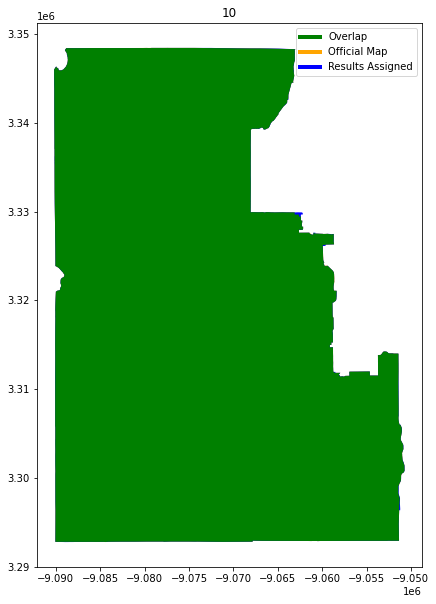

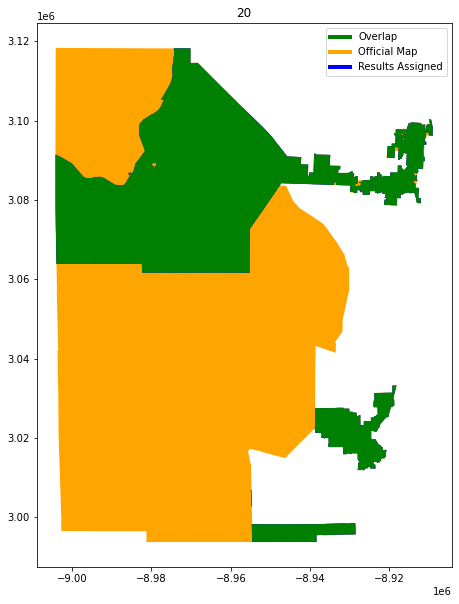

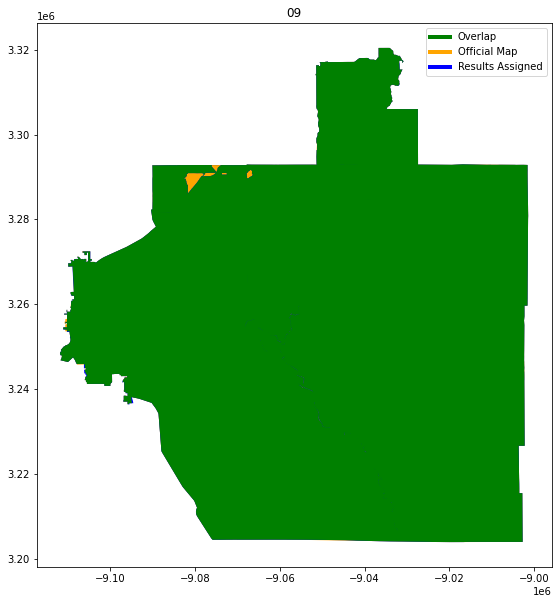

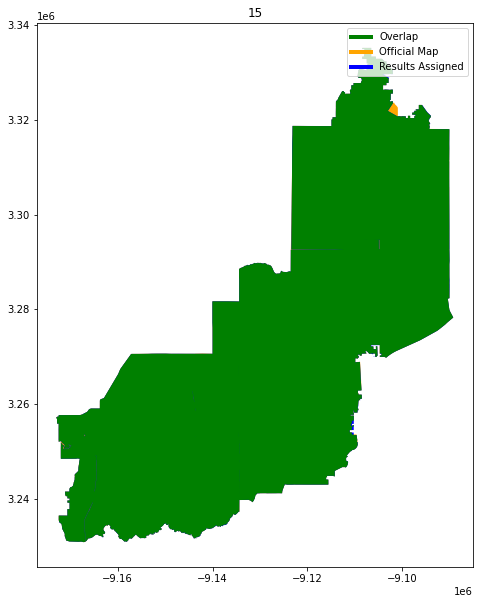

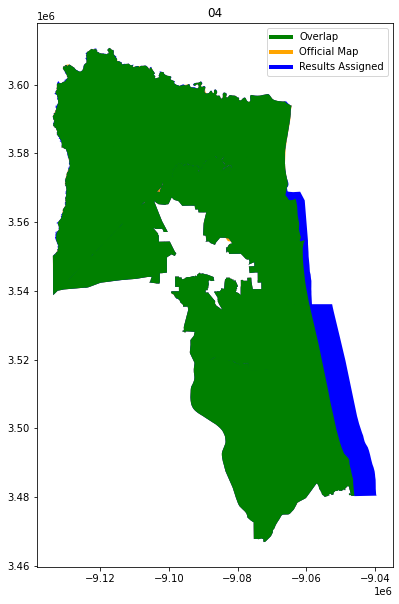

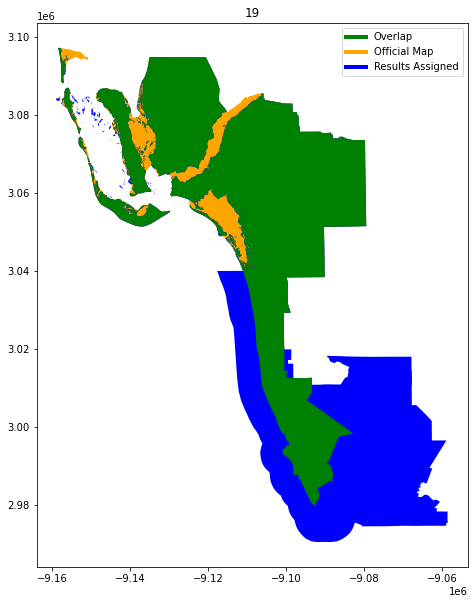

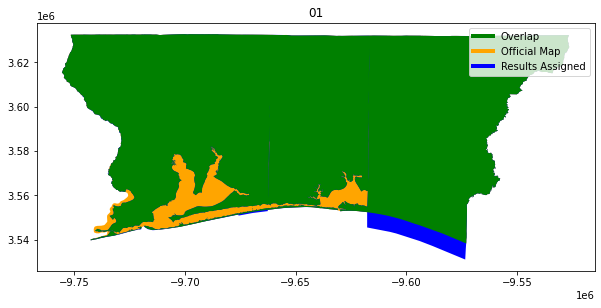

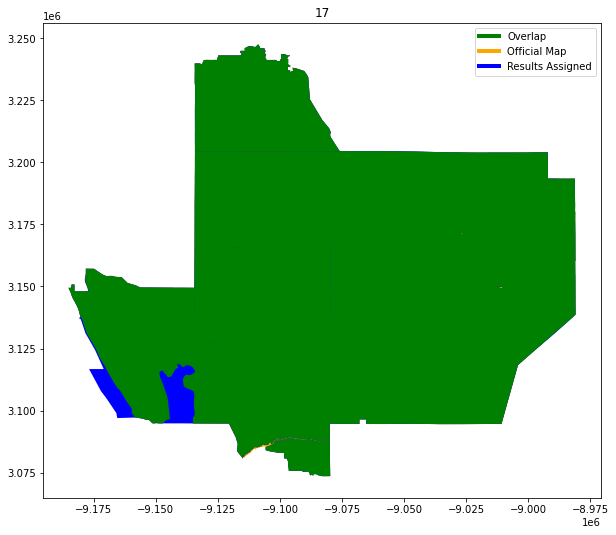

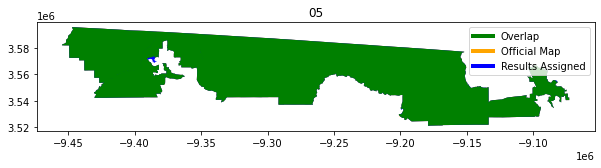

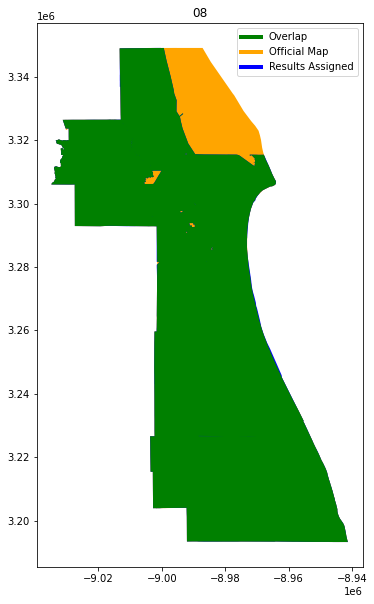

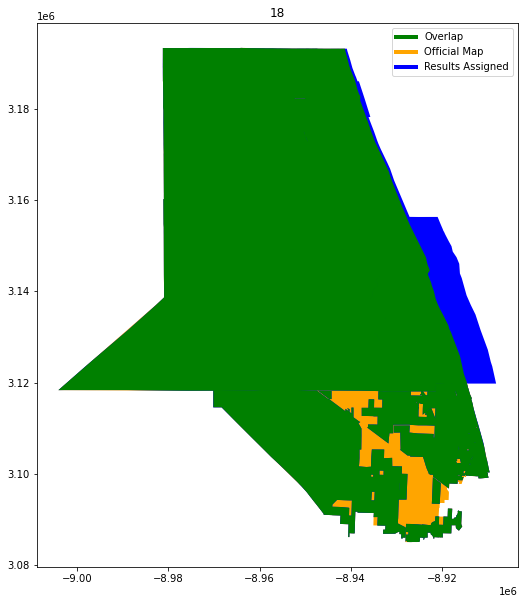

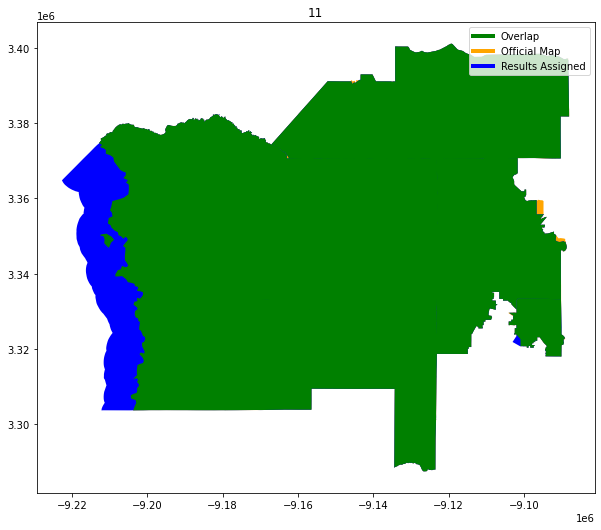

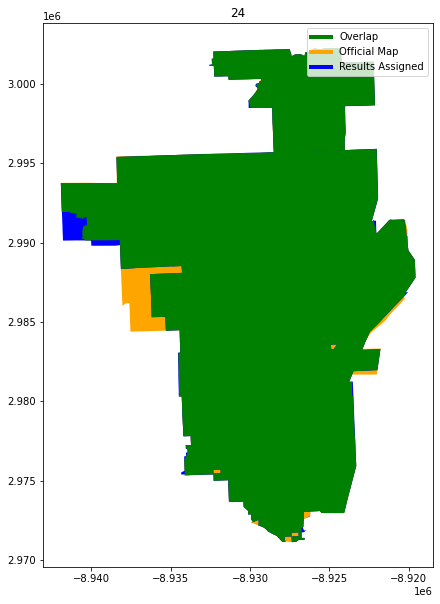

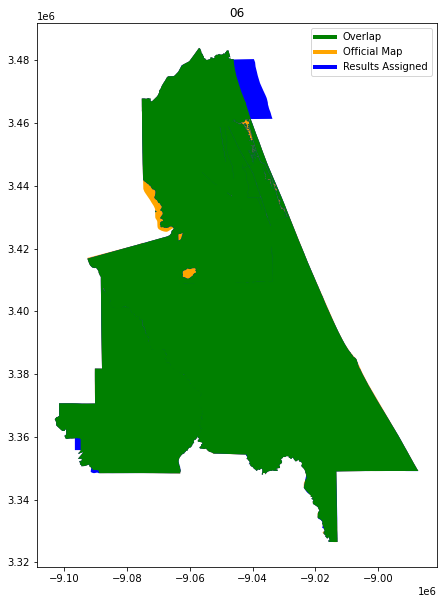

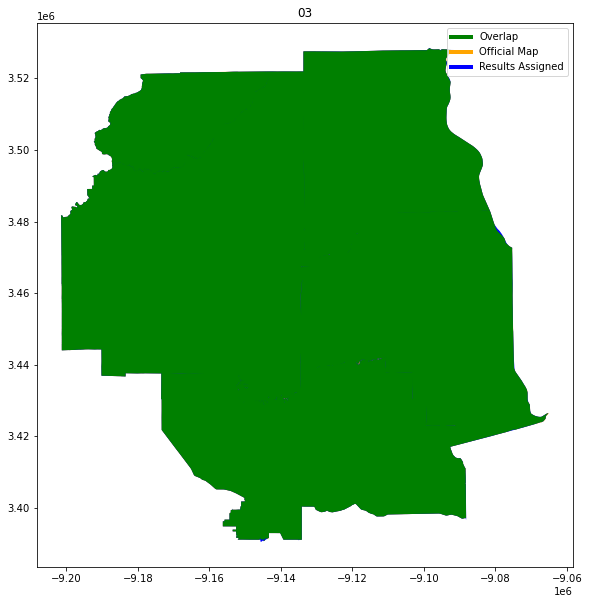

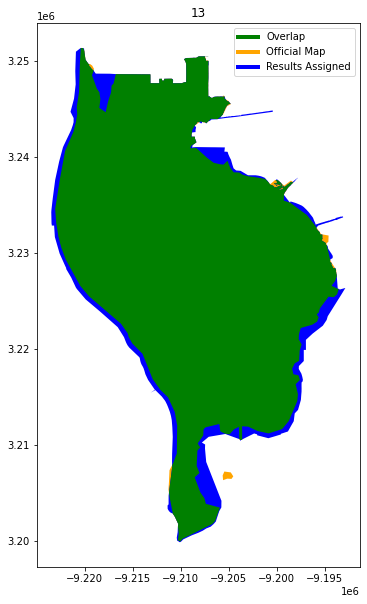

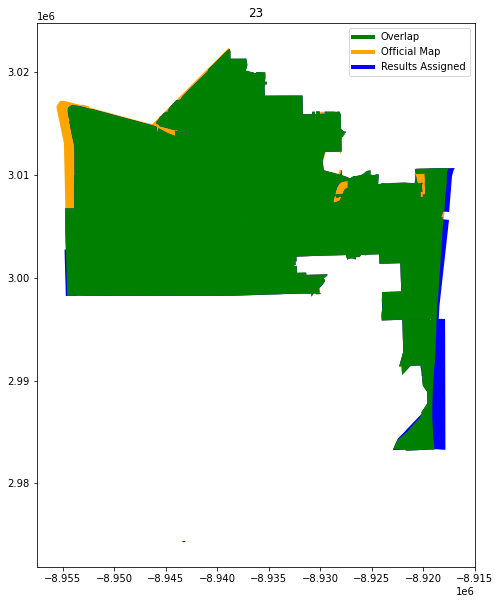

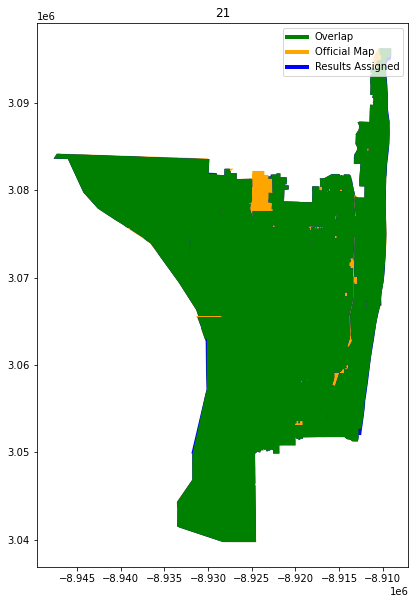

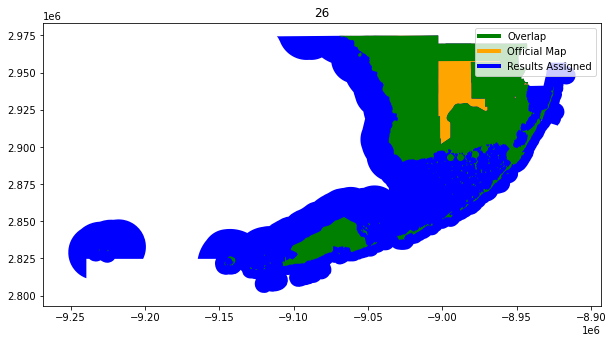

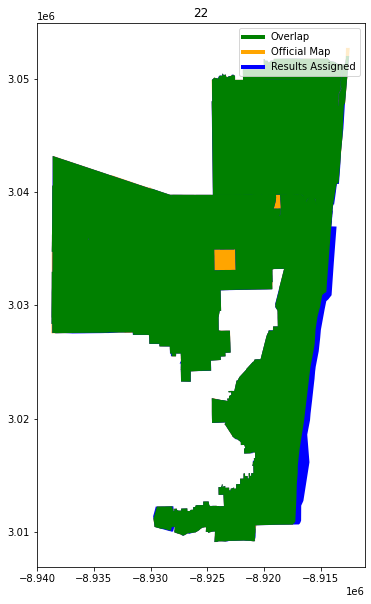

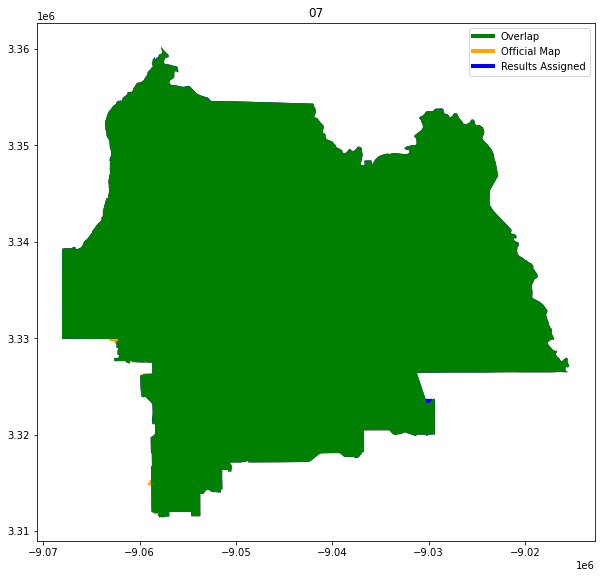

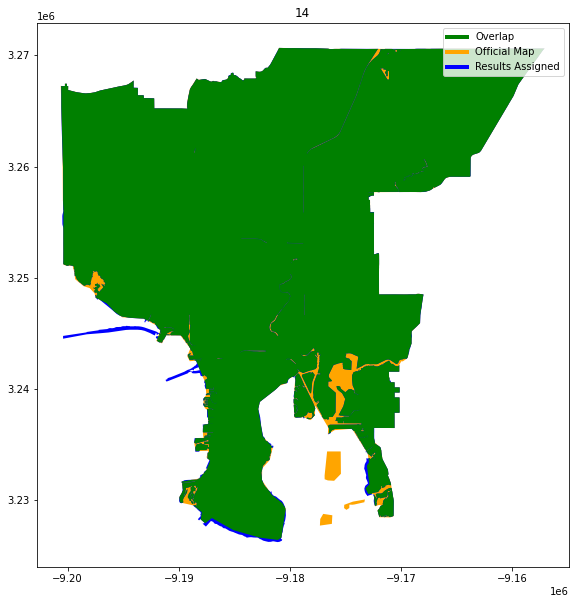

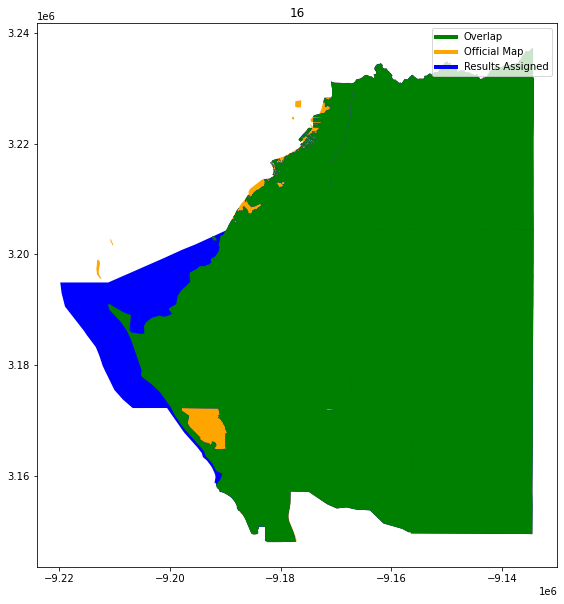

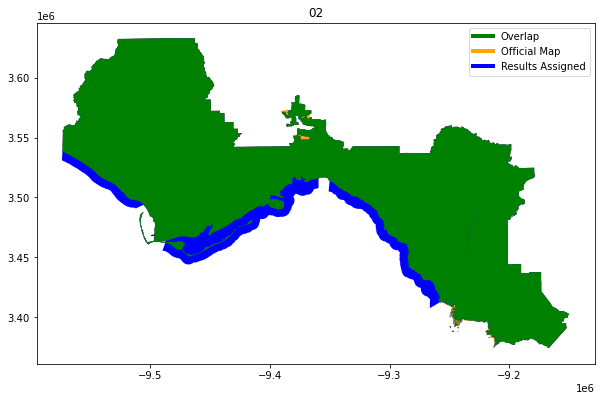

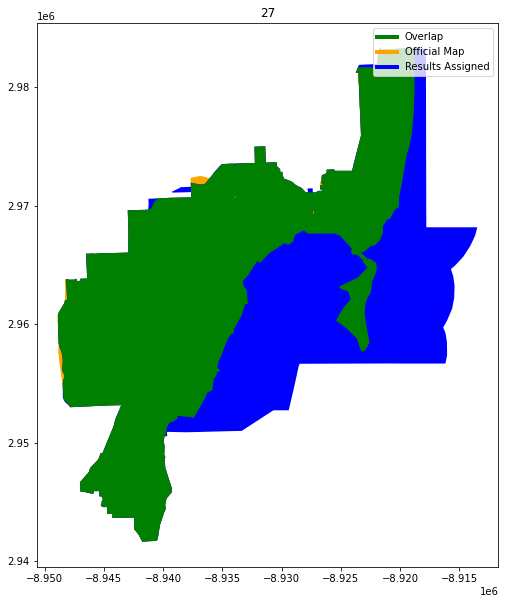

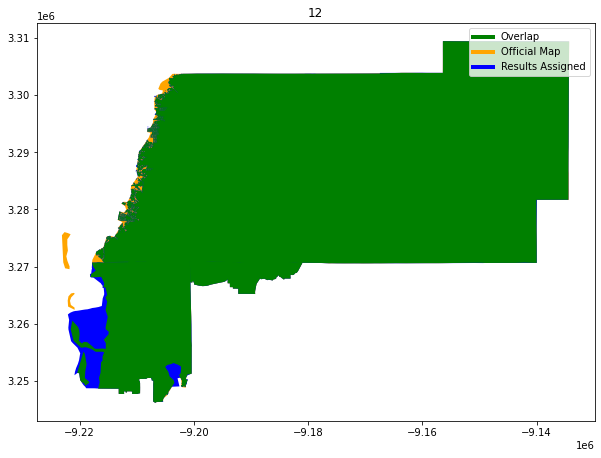

In [100]:
compare_geometries(fl_cong_shapefile,filtered_results,"Official Map","Results Assigned","CONG_DIST",area_threshold=.1)

## Election Totals Checks

#### Can't easily verify write-in votes on the official results, as write-ins are broken down by candidate

In [101]:
tot_sum = 0
for val in state_data_columns:
    tot_sum += sum(join_attempt_two[val])
    print(val, sum(join_attempt_two[val]))

GCON01DEHR 149172
GCON01NORA 6038
GCON01RGAE 283352
GCON02OWRI 23465
GCON02RDUN 305337
GCON03DCHR 167326
GCON03RCAM 223075
GCON04DDEE 196423
GCON04OWRI 437
GCON04RRUT 308497
GCON05DLAW 219463
GCON05RADL 117510
GCON06DCUR 172305
GCON06OWRI 534
GCON06RWAL 265393
GCON07DMUR 224946
GCON07NGAR 5753
GCON07RVAL 175750
GCON08DKEN 177695
GCON08RPOS 282093
GCON09DSOT 240724
GCON09OWRI 415
GCON09ROLS 188889
GCON10DDEM 239434
GCON10OWRI 395
GCON10RFRA 136889
GCON11DCOT 158094
GCON11RWEB 316979
GCON12DWAL 168194
GCON12RBIL 284941
GCON13DCRI 215405
GCON13OWRI 443
GCON13RLUN 190713
GCON14DCAS 224240
GCON14RQUI 147896
GCON15DCOH 174297
GCON15RFRA 216374
GCON16DGOO 215683
GCON16RBUC 269001
GCON17DELL 140487
GCON17NMUR 5396
GCON17RSTE 266514
GCON18DKEI 186674
GCON18NMIL 9760
GCON18RMAS 253286
GCON19DBAN 172146
GCON19OWRI 62
GCON19RDON 272440
GCON20DHAS 253661
GCON20RMUS 68748
GCON21DFRA 237925
GCON21NMAL 7544
GCON21OWRI 284
GCON21RLOO 157612
GCON22DDEU 235764
GCON22RPRU 166553
GCON23DSCH 221239
GCON23OW

In [102]:
def county_totals_check(source_df,column_list,county_col,full_print=False):
    """Compares the totals of two election result dataframes at the county level

    Args:
      partner_df: DataFrame of election results we are comparing against
      source_df: DataFrame of election results we are comparing to
      column_list: List of races that there are votes for
      county_col: String of the column name that contains county information
      full_print: Boolean specifying whether to print out everything, including counties w/ similarities

    Returns:
      Nothing, only prints out an analysis
    """
    
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        print(race)
        diff = source_df.groupby([county_col]).sum()[race]
        for val in diff.index.values.tolist():
            if val in ["MON","SEM"]:
                print("\t"+val + ": "+ str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")

In [103]:
county_totals_check(join_attempt_two,state_data_columns,"county",True)

***Countywide Totals Check***

GCON01DEHR
	MON: 0 votes
	SEM: 0 votes
GCON01NORA
	MON: 0 votes
	SEM: 0 votes
GCON01RGAE
	MON: 0 votes
	SEM: 0 votes
GCON02OWRI
	MON: 0 votes
	SEM: 0 votes
GCON02RDUN
	MON: 0 votes
	SEM: 0 votes
GCON03DCHR
	MON: 0 votes
	SEM: 0 votes
GCON03RCAM
	MON: 0 votes
	SEM: 0 votes
GCON04DDEE
	MON: 0 votes
	SEM: 0 votes
GCON04OWRI
	MON: 0 votes
	SEM: 0 votes
GCON04RRUT
	MON: 0 votes
	SEM: 0 votes
GCON05DLAW
	MON: 0 votes
	SEM: 0 votes
GCON05RADL
	MON: 0 votes
	SEM: 0 votes
GCON06DCUR
	MON: 0 votes
	SEM: 0 votes
GCON06OWRI
	MON: 0 votes
	SEM: 0 votes
GCON06RWAL
	MON: 0 votes
	SEM: 0 votes
GCON07DMUR
	MON: 0 votes
	SEM: 132307 votes
GCON07NGAR
	MON: 0 votes
	SEM: 3511 votes
GCON07RVAL
	MON: 0 votes
	SEM: 119470 votes
GCON08DKEN
	MON: 0 votes
	SEM: 0 votes
GCON08RPOS
	MON: 0 votes
	SEM: 0 votes
GCON09DSOT
	MON: 0 votes
	SEM: 0 votes
GCON09OWRI
	MON: 0 votes
	SEM: 0 votes
GCON09ROLS
	MON: 0 votes
	SEM: 0 votes
GCON10DDEM
	MON: 0 votes
	SEM: 0 votes
GCON10OWRI
	MON: 0 v

## Export File

In [104]:
join_attempt_two.columns

Index(['UNIQUE_ID', 'COUNTYFP', 'pct_std', 'county', 'precinct', 'GCON01DEHR',
       'GCON01NORA', 'GCON01RGAE', 'GCON02OWRI', 'GCON02RDUN', 'GCON03DCHR',
       'GCON03RCAM', 'GCON04DDEE', 'GCON04OWRI', 'GCON04RRUT', 'GCON05DLAW',
       'GCON05RADL', 'GCON06DCUR', 'GCON06OWRI', 'GCON06RWAL', 'GCON07DMUR',
       'GCON07NGAR', 'GCON07RVAL', 'GCON08DKEN', 'GCON08RPOS', 'GCON09DSOT',
       'GCON09OWRI', 'GCON09ROLS', 'GCON10DDEM', 'GCON10OWRI', 'GCON10RFRA',
       'GCON11DCOT', 'GCON11RWEB', 'GCON12DWAL', 'GCON12RBIL', 'GCON13DCRI',
       'GCON13OWRI', 'GCON13RLUN', 'GCON14DCAS', 'GCON14RQUI', 'GCON15DCOH',
       'GCON15RFRA', 'GCON16DGOO', 'GCON16RBUC', 'GCON17DELL', 'GCON17NMUR',
       'GCON17RSTE', 'GCON18DKEI', 'GCON18NMIL', 'GCON18RMAS', 'GCON19DBAN',
       'GCON19OWRI', 'GCON19RDON', 'GCON20DHAS', 'GCON20RMUS', 'GCON21DFRA',
       'GCON21NMAL', 'GCON21OWRI', 'GCON21RLOO', 'GCON22DDEU', 'GCON22RPRU',
       'GCON23DSCH', 'GCON23OWRI', 'GCON23RSPA', 'GCON24DWIL', 'GCON24NOLI

In [105]:
join_attempt_two = join_attempt_two[['UNIQUE_ID', 'COUNTYFP', 'pct_std', 'county', 'precinct', 
        'CONG_DIST','GCON01DEHR',
       'GCON01NORA', 'GCON01RGAE', 'GCON02OWRI', 'GCON02RDUN', 'GCON03DCHR',
       'GCON03RCAM', 'GCON04DDEE', 'GCON04OWRI', 'GCON04RRUT', 'GCON05DLAW',
       'GCON05RADL', 'GCON06DCUR', 'GCON06OWRI', 'GCON06RWAL', 'GCON07DMUR',
       'GCON07NGAR', 'GCON07RVAL', 'GCON08DKEN', 'GCON08RPOS', 'GCON09DSOT',
       'GCON09OWRI', 'GCON09ROLS', 'GCON10DDEM', 'GCON10OWRI', 'GCON10RFRA',
       'GCON11DCOT', 'GCON11RWEB', 'GCON12DWAL', 'GCON12RBIL', 'GCON13DCRI',
       'GCON13OWRI', 'GCON13RLUN', 'GCON14DCAS', 'GCON14RQUI', 'GCON15DCOH',
       'GCON15RFRA', 'GCON16DGOO', 'GCON16RBUC', 'GCON17DELL', 'GCON17NMUR',
       'GCON17RSTE', 'GCON18DKEI', 'GCON18NMIL', 'GCON18RMAS', 'GCON19DBAN',
       'GCON19OWRI', 'GCON19RDON', 'GCON20DHAS', 'GCON20RMUS', 'GCON21DFRA',
       'GCON21NMAL', 'GCON21OWRI', 'GCON21RLOO', 'GCON22DDEU', 'GCON22RPRU',
       'GCON23DSCH', 'GCON23OWRI', 'GCON23RSPA', 'GCON24DWIL', 'GCON24NOLI',
       'GCON24OWRI', 'GCON24RSPI', 'GCON26DMUC', 'GCON26RGIM', 'GCON27DSHA',
       'GCON27OWRI', 'GCON27RSAL', 'geometry']]

In [106]:
if not os.path.exists('./fl_gen_20_prec/'):
    os.mkdir('./fl_gen_20_prec/')

join_attempt_two.to_file('./fl_gen_20_prec/fl_gen_20_cong_prec.shp')